# Methods for Data Science: Course Work 2

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

In [2]:
#import the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [518]:
#read in the training data with 600 images and test data with 100
train = pd.read_csv("MNIST_train.csv")
test = pd.read_csv("MNIST_test.csv")

In [520]:
#visualise the top of each dataframe to see the label column followed by a column for every pixel
print(train.head())
print(test.head())

   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      4    0    0    0    0    0    0    0    0    0  ...      0      0   
1      9    0    0    0    0    0    0    0    0    0  ...      0      0   
2      7    0    0    0    0    0    0    0    0    0  ...      0      0   
3      8    0    0    0    0    0    0    0    0    0  ...      0      0   
4      2    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]
   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      0    0    0    0    0    0    0    0    0    0  ...      0      0   
1      

Normalise the x data by 255 which is the maximum value a pixel can take, so all x values are between 0 and 1. This may slightly increase the learning speed and result in a lower optimal learning rate found.

In [29]:
#convert all the data to numpy
#split the testing and training into the input and the target (label)
#use the identity function  to one hot encode y in order to be able to compare y to the network output
#do this for training and testing

y_train = train["label"].to_numpy()
y_train = np.eye(10)[y_train]
x_train = train.drop(columns=["label"]).to_numpy()/255
y_test = test["label"].to_numpy()
y_test = np.eye(10)[y_test]
x_test = test.drop(columns=["label"]).to_numpy()/255

The procedure is the following. First I will initialise weights and biases according to a multi-layer perceptron with 3 hidden layers. I will divide the data into minibatches randomly and for each minibatch, make a forward pass through the network, updating weights and biases, calculate the gradient of the kl divergence loss function with respect to each weight and bias, and update the weights and the biases by minibatch stochastic gradient descent (update the weights by the gradients scaled by the learning rates). I repeat this process for every minibatch in the data and again for the whole data set once per epoch. Finally, I am able to make a final forward pass with the weights and biases after training and record the final losses for each learning rate and the accuracy that the prediction makes. The output is one-hot encoded so an accurate prediction correponds to when the maximum label according to the probabilities outputted by the softmax function correspond to the label value, and the accuracy is the average over these scores of 0 or 1 for correct or incorrect prediction.

In [521]:
#class implementation of the multi-layer perceptron
class Layer:
    """class which stores 1 layer of the perceptron and its attributes"""
    def __init__(self):
        return

    def forward(self, input,testing=False):
        return input

    def backward(self, input, gradient_out):
        number_size = input.shape[1]
        d_layer_d_in = np.eye(number_size)
        return gradient_out @ d_layer_d_in

In [522]:
class Dense(Layer):
    """class which applies dense properties to a layer"""
    def __init__(self, input_size, output_size, learning_rate=0.1):
        """function to initialise the learning rate, weights and biases of a layer as class attributes"""
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2./(input_size + output_size))
        #make biases a vector of the right size
        self.biases = np.zeros(output_size)

    def forward(self, input,testing=False):
        """makes one dense layer forward pass"""
        return input@self.weights + self.biases

    def backward(self, input, gradient_out):
        """makes one dense layer backwards pass"""
        gradient_in = gradient_out@self.weights.T
        gradient_weights = input.T @ gradient_out
        gradient_biases = gradient_out.mean(axis=0)*input.shape[0]
        
        #perform stochastic gradient descent on a batch by updating weights and biases
        self.weights -= self.learning_rate * gradient_weights
        self.biases -= self.learning_rate * gradient_biases
        
        return gradient_in

In [523]:
class SoftPlus(Layer):
    """class which applies softplus function to a layer"""
    def __init__(self):
        return
    
    def forward(self, input,testing=False):
        """softplus forwards function"""
        return np.log1p(np.exp(-np.abs(input))) + np.maximum(input, 0)

    def backward(self, input, gradient_out):
        """backwards softplus gradient"""
        return 1/(1 + np.exp(-input))*gradient_out

Softplus function is analogous to a smooth ReLU function, and sets negative values to 0 and it mostly linear on positive values.

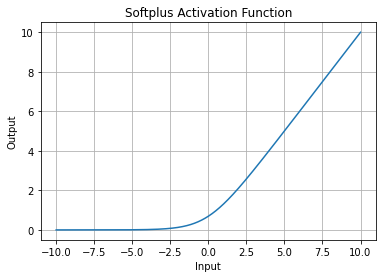

In [529]:
def softplus(x):
    return np.log(1 + np.exp(x))

x = np.linspace(-10, 10, 1000)
y = softplus(x)

plt.plot(x, y)
plt.title('Softplus Activation Function')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid(True)
plt.show()

In [524]:
def iterate_minibatches(inputs, targets, batch_size, shuffle=False):
    """function to create minibatches for stochastic gradient descent"""
    if shuffle:
        #change the order of indices for every epoch so you do not run through 
        #the data in the same fashion
        #so permute the dataset
        indices = np.random.permutation(len(inputs))
    for start_index in range(0, len(inputs) - batch_size + 1, batch_size):
        #for each minibatch up to the number of minibatches take cuts
        if shuffle:
            cut = indices[start_index:start_index + batch_size]
        else:
            cut = slice(start_index, start_index + batch_size)
        #return the x and y both at the same cut indices
        yield inputs[cut], targets[cut]

In [525]:
def softmax(logits):
    """softmax function"""
    softmax = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    softmax_probability = softmax / np.sum(softmax, axis=1, keepdims=True)
    return softmax_probability

The softmax function first normalizes the logits by subtracting the maximum value along each row from each element, to avoid numerical issues with large numbers. This does not affect the function output. Then the softmax outputs the exponential of each logit scaled by the sum of the exponentials, i.e. as a probability, where each element in the resulting vector is a probability of predicting that label index.

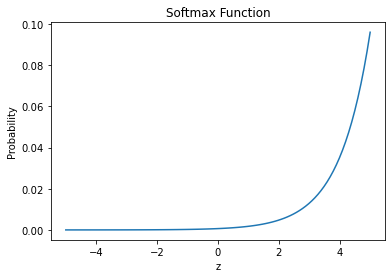

In [532]:
z = np.linspace(-5, 5, 100)
probs = softmax(z)

plt.plot(z, probs)
plt.title('Softmax Function')
plt.xlabel('z')
plt.ylabel('Probability')
plt.show()


In [534]:
def KL_divergence(softmax_probability, target_probability):
    """kl divergence function"""
    #clip to avoid overflow errors
    softmax_probability = np.clip(softmax_probability, 1e-10, 1)
    return -np.log(softmax_probability[target_probability==1])

The pointwise kl divergence is defined as the true y value multiplied by the log of the ratio of the true y value and the y predicted. KL divergence is a measure of relative entropy, i.e. how different 2 distributions are to each other.

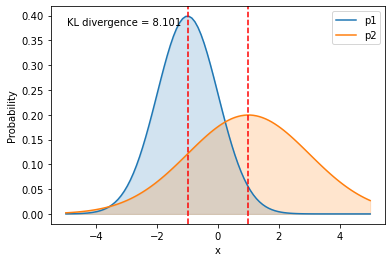

In [533]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2))
x = np.linspace(-5, 5, 100)
mu1, sigma1 = -1, 1
mu2, sigma2 = 1, 2
p1 = gaussian(x, mu1, sigma1)
p2 = gaussian(x, mu2, sigma2)

# compute KL divergence between p1 and p2
kl_div = np.sum(np.where(p1 != 0, p1 * np.log(p1/p2), 0))

# plot the two distributions and the KL divergence
fig, ax = plt.subplots()
ax.plot(x, p1, label='p1')
ax.plot(x, p2, label='p2')
ax.axvline(x=mu1, color='r', linestyle='--')
ax.axvline(x=mu2, color='r', linestyle='--')
ax.fill_between(x, p1, color='C0', alpha=0.2)
ax.fill_between(x, p2, color='C1', alpha=0.2)
ax.annotate(f'KL divergence = {kl_div:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
ax.set_xlabel('x')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


The gradient of KL divergence applied to the softmax function with respect to the last pre-activation is easier to derive than finding these gradients separately. The combined gradient is the difference of the softmax output and the target scaled by the softmax output.

In [527]:
def softmax_and_kl_gradient(logits, target_probability):
    """combined gradient of the softmax function combined with the kl divergence loss"""
    softmax = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    softmax_probability = softmax / np.sum(softmax, axis=1, keepdims=True)
    return (softmax_probability - target_probability)/ softmax_probability.shape[0]

In [528]:
class NeuralNetwork:
    """class which implements the neural network properties"""
    def __init__(self):
        """initialise list to store the network layers"""
        self.network = []

    def get_network(self, in_shape=784, hidden_width=200, out_shape=10, learning_rate=0):
        """apply dense forward function to the input layer, then softplus function"""
        #apply the dense layer followed by softplus 3 times then dense again before
        #the final softmax layer for output
        #initialise the dense layers to the correct sizes
        self.network = []
        self.network.append(Dense(in_shape, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, out_shape, learning_rate))

    def forward(self, X, testing=False):
        """forwards propagate the weights and biases on each dense layer"""
        outputs = []
        X_input = X.copy()
        # Loop through every dense layer
        for i, layer in enumerate(self.network):
            #add the the correct weights and biases
            outputs.append(layer.forward(X_input, testing=testing))
            #take the final output
            X_input = outputs[-1]
            #for our histograms, we want only the 1st activation layer output
            #so if the index is one and we are in testing mode we output the activation
            #after the first layer
            if i==1:
                if testing:
                    activation1 = outputs[-1]
                    return activation1
        return outputs

    def predict(self,X):
        """predicts the output by taking the argmax after the softmax function is used""" 
        prediction = self.forward(X)[-1]
        return np.argmax(prediction, axis=-1)

    def train(self, X, y):
        """function to train on a minibatch, forward propagate to get the activations then backwards propagate to 
        update all the weights and biases based on the gradient with respect to the loss function.
        """
        #forward pass
        activations = self.forward(X)
        inputs = [X]+layer_activations
        softmax_probability = activations[-1]
        # Compute the loss and the initial gradient
        loss = KL_divergence(softmax(softmax_probability), y)
        gradient_loss = softmax_and_kl_gradient(softmax_probability, y)
        for index in range(len(self.network))[::-1]:
            layer = self.network[index]
            gradient_loss = layer.backward(inputs[index], gradient_loss)
        #return the average loss 
        return np.mean(loss)

    def fit(self, X_train, y_train, X_test, y_test, epochs=40, learning_rate=0):
        """fit the model by training for 40 epochs"""
        #define empty lists to store the training and validation
        #accuracies and losses to plot them per epoch
        train_accuracy = []
        validation_accuracy = []
        train_loss = []
        validation_loss = []

        self.get_network(input_size=X_train.shape[1], learning_rate=learning_rate)
        #iterate over the number of epochs
        for epoch in range(epochs):
            loss = []
            #iterate over the batches generated every epoch
            for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=128, shuffle=True):
                loss.append(self.train(x_batch, y_batch))
            # find the losses and accuracies
            activations = self.forward(X_train,testing=False)
            softmax_probabilities = activations[-1]
            train_loss.append(np.mean(KL_divergence(softmax(softmax_probs), y_train)))
            activations = self.forward(X_test)
            softmax_probabilities = activations[-1]
            #calcluate the kl divergence loss of the output with the test data
            validation_loss.append(np.mean(KL_divergence(softmax(softmax_probabilities), y_test)))
            #accuracy of prediction against the training and against the test data
            train_accuracy.append(np.mean(self.predict(X_train)==np.argmax(y_train, axis=1)))
            validation_acc.append(np.mean(self.predict(X_test)==np.argmax(y_test, axis=1)))

        return train_accuracy, validation_accuracy, train_loss, validation_loss

In [270]:
#call an instance of the neural network without dropout for later
neural_network_no_drop = NeuralNetwork()

In [40]:
#test the function on a learning rate of 0.1
train_accuracy, validation_accuracy, train_loss, validation_loss = neural_network_no_drop.fit(x_train, y_train, x_test, y_test, learning_rate=0.1)

In [41]:
#training the neural network over 5 learning rates in the given range and recording the final loss
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
final_train_losses = []
final_val_losses = []
for l in learning_rates:
    neural_network = NeuralNetwork()
    train_accuracy, val_accuracy, train_loss, validation_loss = neural_network.fit(x_train, y_train, x_test, y_test, learning_rate=l)
    #store the final loss for every learning rate
    final_train_losses.append(train_loss[-1])
    final_val_losses.append(validation_loss[-1])
#define final train loss as the loss on the last epoch averaged over batches while training, and 
#validation loss as the loss calculated with the final parameters on the whole set

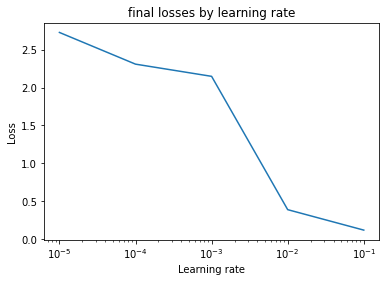

In [43]:
#plot the final losses against the learning rates for testing
plt.plot(learning_rates,final_train_losses)
plt.title("final losses by learning rate")
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.show()

In [44]:
final_train_losses

[2.7246056945887385,
 2.307362138907011,
 2.146840596501495,
 0.39235236293628417,
 0.12303316303122862]

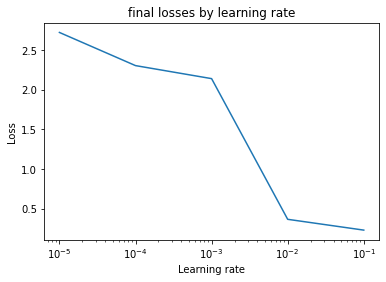

In [45]:
#plot the validation losses too
plt.plot(learning_rates,final_val_losses)
plt.title("final losses by learning rate")
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.show()

We can observe that as the learning rate increase in the given range, the final loss both in the training and validation cases decrease monotonically, meaning that 0.1 has the lowest loss hence the probability distribution produced by the fitted model is closest to the probability distribution of the test data after one-hot encoding. The curve decreases more slowly until 0.001 then quickly to 0.01, where the loss decreases from 2 to 0.5, then decreases a bit more to 0.1.

THese results can be explained by the fact that when the learning rate is smaller than 0.1, the stepsize of gradient descent is smaller hence the solution though it is converging in the right direction requires too long to convergence and does not reach as low a loss after 40 epocs. We might expect for very large learning rates to overshoot and miss the minima as the stepsize would then be too large to properly descend, but we have not reached this point when increasing to just 0.1.

Hence we set 0.1 as the optimal learning rate.

1.1.2

I now retrain the MLP using the determined optimal learning rate of 0.1.

In [50]:
#call an instance of the neural network
neural_network = NeuralNetwork()

In [51]:
train_acc, val_acc, train_loss, val_loss = neural_network.fit(x_train, y_train, x_test, y_test, learning_rate=0.1)

We can see that as the number of epochs increases, both the training loss and testing loss decrease, first quickly up to about 5 epochs then more slowly and will take longer than 40 epochs to converge to a loss of 0. The curves are not smooth but rather slightly bumpy and the training loss curve is below the test loss curve. This is because while the training loss is almost perfectly fitted, the model does not completely generalise to the test data, though it does so very well.

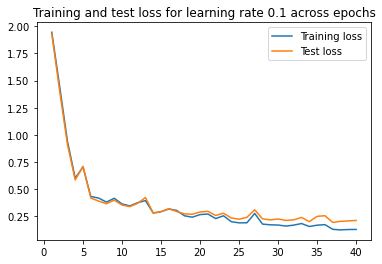

In [54]:
#plot the training loss and accuracy at the end of every epoch for 40 epochs with rate 0.1
plt.plot(np.arange(1,41),train_loss,label="Training loss")
plt.plot(np.arange(1,41),val_loss,label="Test loss")
plt.title("Training and test loss for learning rate 0.1 across epochs")
plt.legend()
plt.show()

As the loss decreases, the accuracies increase. We see a similar trend, whereby the training accuracy is slightly better than test accuracy, the curve are bumpy and both tend towards accuracy of 1, corresponding to perfect prediction, as the number of epochs is increased.

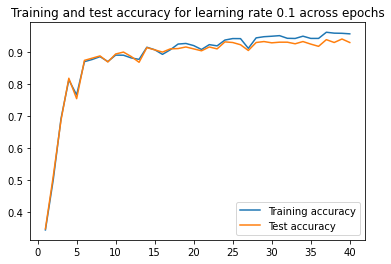

In [55]:
plt.plot(np.arange(1,41),train_acc,label="Training accuracy")
plt.plot(np.arange(1,41),val_acc,label="Test accuracy")
plt.title("Training and test accuracy for learning rate 0.1 across epochs")
plt.legend()
plt.show()

1.1.3

In [535]:
class NeuralNetwork:
    """class which implements the neural network properties"""
    def __init__(self):
        """initialise list to store the network layers"""
        self.network = []

    def get_network(self, in_shape=784, hidden_width=50, out_shape=10, learning_rate=0):
        """apply dense forward function to the input layer, then softplus function"""
        #apply the dense layer followed by softplus 3 times then dense again before
        #the final softmax layer for output
        #initialise the dense layers to the correct sizes
        self.network = []
        self.network.append(Dense(in_shape, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, out_shape, learning_rate))

    def forward(self, X, testing=False):
        """forwards propagate the weights and biases on each dense layer"""
        outputs = []
        X_input = X.copy()
        # Loop through every dense layer
        for i, layer in enumerate(self.network):
            #add the the correct weights and biases
            outputs.append(layer.forward(X_input, testing=testing))
            #take the final output
            X_input = outputs[-1]
            #for our histograms, we want only the 1st activation layer output
            #so if the index is one and we are in testing mode we output the activation
            #after the first layer
            if i==1:
                if testing:
                    activation1 = outputs[-1]
                    return activation1
        return outputs

    def predict(self,X):
        """predicts the output by taking the argmax after the softmax function is used""" 
        prediction = self.forward(X)[-1]
        return np.argmax(prediction, axis=-1)

    def train(self, X, y):
        """function to train on a minibatch, forward propagate to get the activations then backwards propagate to 
        update all the weights and biases based on the gradient with respect to the loss function.
        """
        #forward pass
        activations = self.forward(X)
        inputs = [X]+layer_activations
        softmax_probability = activations[-1]
        # Compute the loss and the initial gradient
        loss = KL_divergence(softmax(softmax_probability), y)
        gradient_loss = softmax_and_kl_gradient(softmax_probability, y)
        for index in range(len(self.network))[::-1]:
            layer = self.network[index]
            gradient_loss = layer.backward(inputs[index], gradient_loss)
        #return the average loss 
        return np.mean(loss)

    def fit(self, X_train, y_train, X_test, y_test, epochs=40, learning_rate=0):
        """fit the model by training for 40 epochs"""
        #define empty lists to store the training and validation
        #accuracies and losses to plot them per epoch
        train_accuracy = []
        validation_accuracy = []
        train_loss = []
        validation_loss = []

        self.get_network(input_size=X_train.shape[1], learning_rate=learning_rate)
        #iterate over the number of epochs
        for epoch in range(epochs):
            loss = []
            #iterate over the batches generated every epoch
            for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=128, shuffle=True):
                loss.append(self.train(x_batch, y_batch))
            # find the losses and accuracies
            activations = self.forward(X_train,testing=False)
            softmax_probabilities = activations[-1]
            train_loss.append(np.mean(KL_divergence(softmax(softmax_probs), y_train)))
            activations = self.forward(X_test)
            softmax_probabilities = activations[-1]
            #calcluate the kl divergence loss of the output with the test data
            validation_loss.append(np.mean(KL_divergence(softmax(softmax_probabilities), y_test)))
            #accuracy of prediction against the training and against the test data
            train_accuracy.append(np.mean(self.predict(X_train)==np.argmax(y_train, axis=1)))
            validation_acc.append(np.mean(self.predict(X_test)==np.argmax(y_test, axis=1)))

        return train_accuracy, validation_accuracy, train_loss, validation_loss

I retrain the model having reduced the width of the hidden layers to 50.

In [136]:
neural_network = NeuralNetwork()

In [137]:
train_acc50, val_acc50, train_loss50, val_loss50 = neural_network.fit(x_train, y_train, x_test, y_test, learning_rate=0.1,epochs=40)

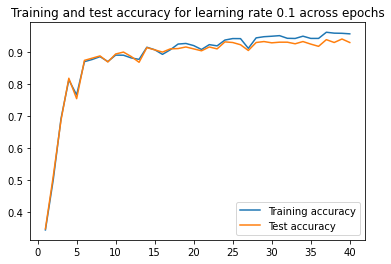

In [59]:
#plot the previous shape of the accuracy curve with 200 width per hidden layer
plt.plot(np.arange(1,41),train_acc,label="Training accuracy")
plt.plot(np.arange(1,41),val_acc,label="Test accuracy")
plt.title("Training and test accuracy for learning rate 0.1 across epochs")
plt.legend()
plt.show()

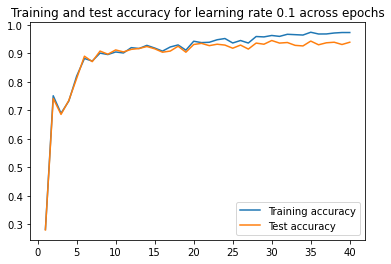

In [138]:
#plot the accuracy curves for testing and training for hidden layer width 50
plt.plot(np.arange(1,41),train_acc50,label="Training accuracy")
plt.plot(np.arange(1,41),val_acc50,label="Test accuracy")
plt.title("Training and test accuracy for learning rate 0.1 across epochs")
plt.legend()
plt.show()

I also plot the difference between the accuracies of the model with 200 width of the hidden layers and with 50 neurons per hidden layer. The graph is below 0 at the start until around 10 epochs, which means that initially the accuracy of the 50 neuron model is higher. This is because initially, this model may take less time to train as there are fewer neuron weights and biases to fit. Then after a while the difference fluctuates around 0, meaning that both models for training and testing data perform around the same. We might expect the 50 neuron model to perform better after just a few epochs as it fits faster then worse eventually on the training data as the 200 neuron model eventually as it has more weights could fit the data much more closely. However, this effect is not seen in practise, i.e. we can conclude that more than 50 neurons per hidden layer were not required to capture the complexity of the system.

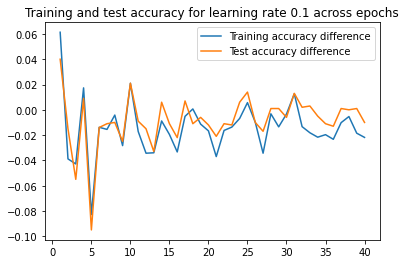

In [61]:
plt.plot(np.arange(1,41),[train_acc[i]-train_acc50[i] for i in range(len(train_acc))],label="Training accuracy difference")
plt.plot(np.arange(1,41),[val_acc[i]-val_acc50[i] for i in range(len(val_acc))],label="Test accuracy difference")
plt.title("Training and test accuracy for learning rate 0.1 across epochs")
plt.legend()
plt.show()

1.1.4

I will introduce dropout by dropping out activations randomly at each hidden layer by defining a Bernouilli mask which sets a neuron in the layer to 0 with a probability of 0.2 and then also stores the indices at which the neuron was set to 0 to make sure that the gradient is not altered in these directions on the backward pass. Create a condition such that when testing, neurons are not dropped out, as we only which to dropout during training to prevent over fitting but want to test the model as a whole. It makes sense to apply the mask of the activation rather than the weight as the softplus function is such that it does not preserve 0s. I also scale the output of each neuron by 1/(1-0.2) in order to increase remaining weights to counter the effect that 0.2 of them are missing.

In [540]:
class SoftPlus(Layer):
    """applies softplus to a layer"""
    def __init__(self):
        #initialise the mask as empty
        self.mask=None
        return
    
    def forward(self, input,testing=False):
        #define the mask to be of the right length and to use a binomial distribution
        #this makes it Bernouilli on each index
        #the mask will set random activations to 0
        #the scaling is included in the mask
        self.mask=np.random.binomial(1,1-0.2, size=input.shape).astype(bool)/(1-0.2)
        #only apply the mask if training, not if testing
        if testing==True:
            return np.log1p(np.exp(-np.abs(input))) + np.maximum(input, 0)
        else:
            return (np.log1p(np.exp(-np.abs(input))) + np.maximum(input, 0))*self.mask

    def backward(self, input, grad_output):
        #apply the mask on the backward pass too
        #rescaling is included so that the gradient is adapted proportionally
        #to how many neurons are having the gradient changed
        return 1/(1 + np.exp(-input))*grad_output*self.mask

In [538]:
#reinstate the version of the MLP which has 200 neurons per hidden layer
class NeuralNetwork:
    """class which implements the neural network properties"""
    def __init__(self):
        """initialise list to store the network layers"""
        self.network = []

    def get_network(self, in_shape=784, hidden_width=200, out_shape=10, learning_rate=0):
        """apply dense forward function to the input layer, then softplus function"""
        #apply the dense layer followed by softplus 3 times then dense again before
        #the final softmax layer for output
        #initialise the dense layers to the correct sizes
        self.network = []
        self.network.append(Dense(in_shape, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, hidden_width, learning_rate))
        self.network.append(SoftPlus())
        self.network.append(Dense(hidden_width, out_shape, learning_rate))

    def forward(self, X, testing=False):
        """forwards propagate the weights and biases on each dense layer"""
        outputs = []
        X_input = X.copy()
        # Loop through every dense layer
        for i, layer in enumerate(self.network):
            #add the the correct weights and biases
            outputs.append(layer.forward(X_input, testing=testing))
            #take the final output
            X_input = outputs[-1]
            #for our histograms, we want only the 1st activation layer output
            #so if the index is one and we are in testing mode we output the activation
            #after the first layer
            if i==1:
                if testing:
                    activation1 = outputs[-1]
                    return activation1
        return outputs

    def predict(self,X):
        """predicts the output by taking the argmax after the softmax function is used""" 
        prediction = self.forward(X)[-1]
        return np.argmax(prediction, axis=-1)

    def train(self, X, y):
        """function to train on a minibatch, forward propagate to get the activations then backwards propagate to 
        update all the weights and biases based on the gradient with respect to the loss function.
        """
        #forward pass
        activations = self.forward(X)
        inputs = [X]+layer_activations
        softmax_probability = activations[-1]
        # Compute the loss and the initial gradient
        loss = KL_divergence(softmax(softmax_probability), y)
        gradient_loss = softmax_and_kl_gradient(softmax_probability, y)
        for index in range(len(self.network))[::-1]:
            layer = self.network[index]
            gradient_loss = layer.backward(inputs[index], gradient_loss)
        #return the average loss 
        return np.mean(loss)

    def fit(self, X_train, y_train, X_test, y_test, epochs=40, learning_rate=0):
        """fit the model by training for 40 epochs"""
        #define empty lists to store the training and validation
        #accuracies and losses to plot them per epoch
        train_accuracy = []
        validation_accuracy = []
        train_loss = []
        validation_loss = []

        self.get_network(input_size=X_train.shape[1], learning_rate=learning_rate)
        #iterate over the number of epochs
        for epoch in range(epochs):
            loss = []
            #iterate over the batches generated every epoch
            for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=128, shuffle=True):
                loss.append(self.train(x_batch, y_batch))
            # find the losses and accuracies
            activations = self.forward(X_train,testing=False)
            softmax_probabilities = activations[-1]
            train_loss.append(np.mean(KL_divergence(softmax(softmax_probs), y_train)))
            activations = self.forward(X_test)
            softmax_probabilities = activations[-1]
            #calcluate the kl divergence loss of the output with the test data
            validation_loss.append(np.mean(KL_divergence(softmax(softmax_probabilities), y_test)))
            #accuracy of prediction against the training and against the test data
            train_accuracy.append(np.mean(self.predict(X_train)==np.argmax(y_train, axis=1)))
            validation_acc.append(np.mean(self.predict(X_test)==np.argmax(y_test, axis=1)))

        return train_accuracy, validation_accuracy, train_loss, validation_loss

In [279]:
neural_net_dropout = NeuralNetwork()

In [188]:
#train a network with dropout
train_acc_drop, val_acc_drop, train_loss_drop, val_loss_drop = neural_net_dropout.fit(x_train, y_train, x_test, y_test, epochs=150,learning_rate=0.5)

With dropout the training and testing accuracy of the model takes longer to converge so I increase the number of epochs to 140 and the learning rate to 0.5 (which helps achieve convergence). Both curves have flattened out so we can infer convergence (as well as the fact that training accuracy has reached 1 almost so the model is perfectly fitting the training data).

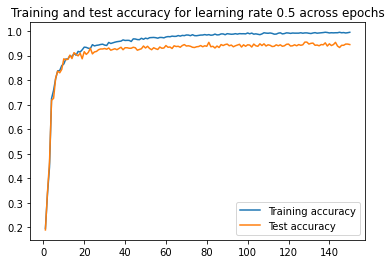

In [189]:
#plot training and testing accuracy with dropout
plt.plot(np.arange(1,151),train_acc_drop,label="Training accuracy")
plt.plot(np.arange(1,151),val_acc_drop,label="Test accuracy")
plt.title("Training and test accuracy for learning rate 0.5 across epochs")
plt.legend()
plt.show()

We can observe that with and without dropout both accuracy curve have a similar shape whereby the training accuracy is above testing. The differences are that the dropout curves are smoother perhaps as the presence of dropout prevents a degree of overfitting which may smoothen out the curve for testing. In theory, the difference between testing and training should be slightly smaller as perhaps the presence of dropout by preventing overfitting to particular nodes in the model enables the model the generalise a bit better, however in practise this is hardly visible.

Interestingly, when we increase the epochs to 150 we can better see a trend which was not visible before. As expected, though the training loss keeps decreasing, the test loss starts to increase past around 20 epochs. This suggest we are overfitting to the test data when we train for a long time. Dropout should help with this but actually has a quite negligeable effect.

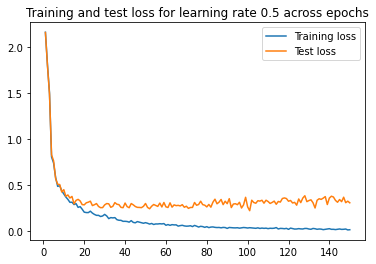

In [192]:
#plot the losses with dropout
plt.plot(np.arange(1,151),train_loss_drop,label="Training loss")
plt.plot(np.arange(1,151),val_loss_drop,label="Test loss")
plt.title("Training and test loss for learning rate 0.5 across epochs")
plt.legend()
plt.show()

In [254]:
#I randomly choose a batch which for which I will index the x and y data at the same positions 
indices = np.random.permutation(len(x_train[1]))[:128]

In [256]:
x_batch = x_test[indices]

In [259]:
y_batch = y_test[indices]

I make a forward pass with a random batch of the test data on both the network with and without dropout and get the activation of the first hidden layer.

In [274]:
activation_after = neural_network_no_drop.forward(x_batch,testing=True)

In [282]:
_, activation_with_dropout = neural_net_dropout.forward(x_batch,testing=True)

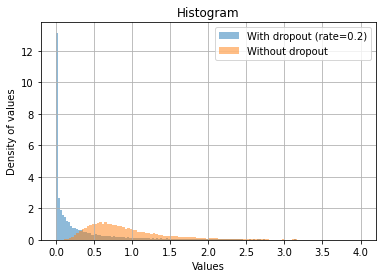

In [283]:
#histogram of the density of the activations in the first layer for the model with and without dropout
plt.Figure(figsize=(20, 20))
plt.hist(activation_with_dropout.flatten(), density=True, bins=150,alpha=0.5 ,label='With dropout (rate=0.2)', range=[0, 4])
plt.hist(activation_after.flatten(), density=True, bins=120, alpha=0.5, label='Without dropout', range=[0, 4])
plt.xlabel('Values')
plt.ylabel('Density of values')
plt.title('Histogram')
plt.legend()
plt.grid()
plt.show()

In the model without dropout, the weights follow a bell curve shape which goes from zero up to about 2 before thinning out, with a mode at 0.6. These are standard outputs to a softplus activation function. However, in the case of dropout, the peak is at 0, as many of the activations have been masked to take a value 0 and the density of many of the other weights are near 0. Many of the weights are near 0, as having dropped many weights to 0 can cause the network to adjust other weights towards 0, as the remaining ones take on a larger role in determining the output (despite rescaling).

Overall, dropout can help reduce overfitting by making the model less complex at each step and also by introducing noise into the model at each step as the neurons being dropped out are random so the model learns to generalise better. Also, dropout is updating fewer parameters at each step.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

In [781]:
#read in the noisy images
train_noisy = pd.read_csv("train_noisy.txt",sep=" ",header=None)
test_noisy = pd.read_csv("test_noisy.txt",sep=" ",header=None)

In [782]:
#visualise the top of the noisy training dataset
train_noisy.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,14.6928,41.54430,0.650907,1.840060,-13.7111,2.70121,6.83062,2.09018,13.268500,-18.1447,...,0.258495,2.873340,-25.03930,1.99615,16.16070,-5.719610,50.55980,21.3238,-12.2810,-14.281200
1,15.3966,3.48577,-9.859870,0.118088,-20.4242,7.05606,-7.52257,-10.05210,36.961100,15.2378,...,-49.228200,-0.718321,-8.45148,11.21700,11.39290,-45.847100,15.66640,-23.1307,-11.7599,23.594000
2,-11.0810,-26.95600,35.461200,17.933200,27.0783,10.06230,-1.39500,-9.70152,-0.209274,-25.9756,...,25.887800,-3.327740,-8.33229,-9.38559,-2.29055,-15.951000,-17.68880,37.2149,-39.6784,1.759430
3,-14.0739,8.25860,-19.878500,-34.264400,17.9438,2.41847,-20.42540,61.76750,-9.236050,28.4589,...,19.365200,1.560740,-13.91450,-40.45090,7.99698,11.741300,2.23981,37.5290,36.7471,-0.942664
4,-17.5225,-8.16958,3.151930,-0.275071,-35.8109,20.09230,22.93350,7.17066,-2.912430,27.5866,...,-18.768500,14.614500,-23.66130,9.91770,-17.43010,-0.103124,10.03820,-29.4632,21.2691,-14.285800


In [783]:
#visualise the noisy test data
test_noisy.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,8.82455,-6.61740,48.61540,-5.04184,2.19220,31.64960,-18.18460,-11.83270,3.75206,-6.59740,...,-10.8209,-21.56690,6.83565,-13.819900,3.3266,1.29783,10.7612,4.84776,7.16925,26.34800
1,-18.45060,1.90898,7.39474,-23.37270,-17.94420,-5.67630,-9.73074,23.36500,3.63704,59.62810,...,27.3251,-6.15665,22.93460,-0.186241,22.4481,-28.23540,-31.3364,-8.55796,-10.30290,-3.35557
2,5.00963,-27.22400,0.34646,-15.00050,35.44280,-7.43275,-12.73030,31.71580,-35.10770,29.89680,...,-24.5475,-13.26450,-7.38790,-12.435500,-30.7695,-26.95300,41.4342,32.90650,-2.81720,1.10606
3,-52.29940,-32.32640,-30.85080,-10.88030,2.22613,23.31280,-20.62340,-7.51939,-31.68270,-9.40265,...,21.8220,-18.29150,30.25120,-3.220380,11.2348,14.88780,-22.1633,30.30760,-45.62070,15.91920
4,-7.50615,-9.10144,-26.21150,-2.05367,48.49020,38.60920,5.80729,-40.17310,-17.97200,-22.59570,...,-18.7403,-7.33475,0.54489,-16.026400,-12.9905,17.05890,21.1008,6.68091,1.12593,37.81060


In [784]:
#convert the images to numpy
images = train_noisy.to_numpy()

For PCA, I will standardise the data such that each image has mean 0 and standard deviation 1. Without standardization, variables with larger scales will dominate the first few principal components, making it difficult to interpret the results in terms of the underlying variables.

In [785]:
def standardise(X):
    """standardisation function for PCA"""
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [786]:
images = standardise(images)

In [787]:
from scipy.sparse import linalg

def pca_function(X,k):
    """function that performs PCA and returns the eigenvectors and eigenvalues in decreasing order of eigenvalue"""
    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

In [788]:
#test the pca function with 3 principal components on the images
pca_function(images,3)

(array([[ 6.86538778, -0.50919764, -1.21428828],
        [ 3.12776743, -2.01715489,  5.66503872],
        [ 4.06272694, -2.18669579,  7.38295095],
        ...,
        [ 4.83618068,  1.12469337,  4.90206279],
        [-3.39954383, -3.4127804 , -6.14955517],
        [ 2.18926351,  2.60484738, -3.57715311]]),
 array([[-2.43140222e-04, -1.24187224e-03, -8.02033047e-04],
        [-1.72524206e-03,  2.04298048e-03,  1.41376766e-05],
        [ 3.33977338e-03, -1.09982863e-03, -9.42307102e-04],
        ...,
        [ 2.85574305e-03, -6.00955879e-04,  3.31253752e-04],
        [ 2.33731767e-03,  4.35968176e-03,  9.43525547e-05],
        [-9.43085490e-04, -6.44500470e-04,  2.80911792e-03]]),
 array([37.74195219, 27.11761256, 23.85789015]))

Text(0, 0.5, 'Eigenvalue')

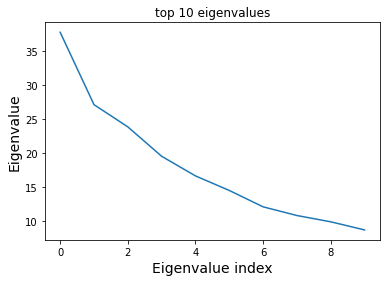

In [789]:
#show the first 10 eigenvalues
k=10
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(images,k) 
plt.plot(eigenvalues);
plt.title("top 10 eigenvalues")
plt.xlabel('Eigenvalue index',fontsize=14)
plt.ylabel('Eigenvalue',fontsize=14)

The eigenvalues returned by PCA correspond to the variance explained by the principal component which is the eigenvector associated. I find the cumulative explained fraction by working out all the eigenvalues and taking the cumulative sum. They are ordered in decreasing order so the most variance is explained by the first ones then less and less so.

In [790]:
#create a list to store the cumulative fractions of the variance explained by PCA
frac=[]
X_pca, eigenvectors, eigenvalues = pca_function(images,783) 
X_pca, eigenvectors, eigenvalues = pca_function(images,783) 
C = 1.0/(len(images)-1) * np.dot(images.T, images)
all_eigenvalues = np.trace(C)
explained_variances =  np.cumsum(eigenvalues)/  all_eigenvalues
for i, value in enumerate(explained_variances):
    frac.append((i+1, ": ", value))
#print(frac)
#display the fraction for every eigenvalue 

From printing frac I can see that the first m value at which 70% of the variance is explained is m=213, and m=298 for 80% and m=408 for 90%.

Text(0, 0.5, 'fraction')

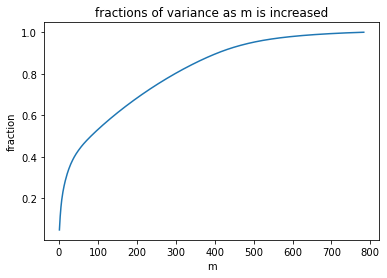

In [791]:
#plot the fraction of variance explained as m increases
plt.plot(range(1,784),explained_variances)
plt.title("fractions of variance as m is increased")
plt.xlabel("m")
plt.ylabel("fraction")

I visualise the first 10 principal components. Some of them look like parts of a digit, which makes sense as these are the highest variance components.

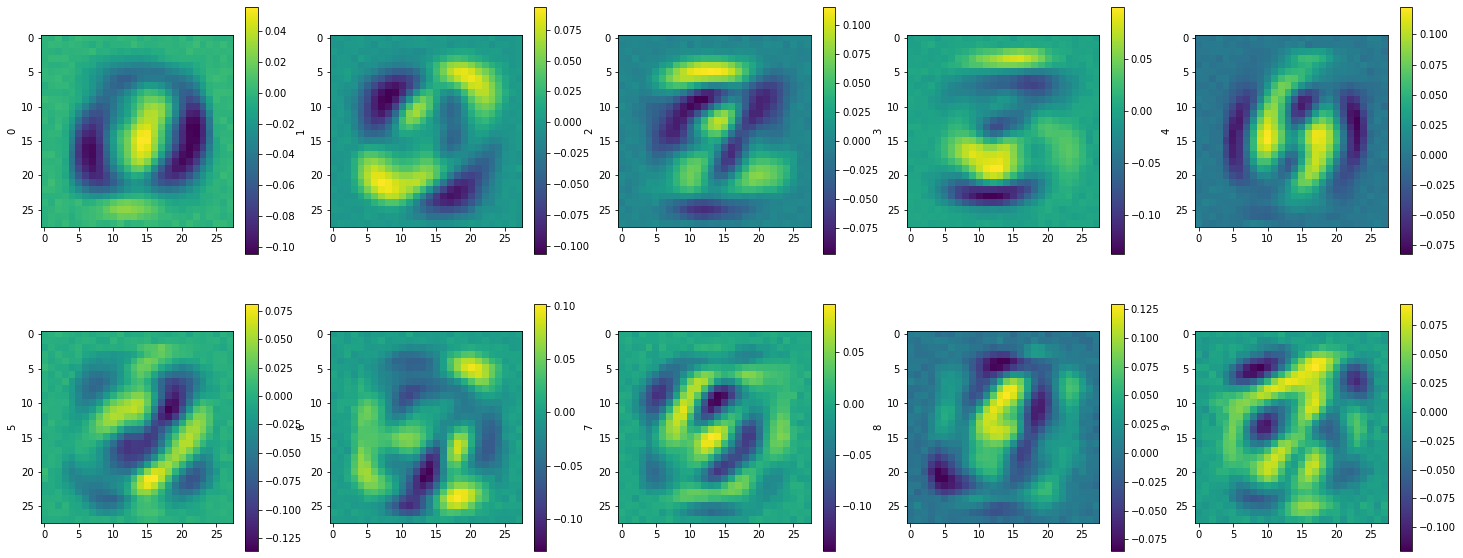

In [801]:
nrow = 2; ncol = 5
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(25,10))
for i,ax in enumerate(axs.reshape(-1)): 
    im = ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_ylabel(str(i))
    fig.colorbar(im,ax=ax)

1.2.2

In NMF, the objective is to ensure that the matrix factors obtained are non-negative and have a meaningful interpretation. In contrast, in PCA, the objective of normalization is to ensure that all variables are treated equally and have the same scale.

Second, the data in NMF is typically non-negative, while the data in PCA can be positive or negative. We can see some negative colours in the plots. Non-negative data can only take on values greater than or equal to zero, while positive and negative data can take on values above and below zero. This means that the normalization method used in NMF needs to take into account the non-negative nature of the data.

Hence, we normalise by subtracting the minimum value and dividing by the difference of the min and max.

In [809]:
def normalize_nmf(X):
    """normalise for NMF method"""
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X)) 
    return X_norm

In [810]:
#get the images again
images = train_noisy.to_numpy()

In [811]:
#normalise in a different way than in PCA
images=normalize_nmf(images)

In [812]:
def cost(X,W,H):
    """chi2 loss function"""
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)

    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return chi2

# choosing the number of dimensions (r, called here k) on which to project
k = 10

# setting the random seed (just so everyone gets the same results...)
np.random.seed(0)

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H = np.random.rand(k, images.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(images.shape[0], k)

# set the number of iterations
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(images))/(W.T.dot(W.dot(H))+pseudo_count)) ## <-- SOLUTION

    # compute the update on W
    W = W * ((images.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count)) ## <-- SOLUTION

    # compute the cost and append to list
    cost_values.append(cost(images,W,H))

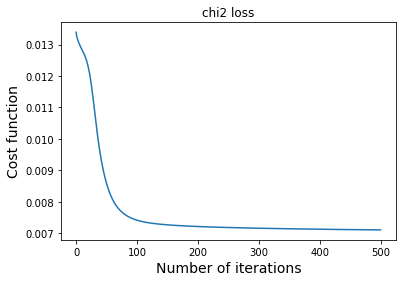

In [813]:
#plot the chi2 loss as you increase the number of iterations in the calculation of NMF
plt.plot(cost_values)
plt.title("chi2 loss")
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('Cost function', fontsize=14)
plt.show()

We can see that the NMF algorithm has convergence as the chi2 loss has reach a plateau, i.e. stops decreasing past around 300 iterations. I have implemented NMF using the Lee and Seung's multiplication rule, updating H and W simultaneously at each step. I have used the chi2 loss function from the notebooks. Below, I visualise the first 10 components found by NMF which are stored in H.

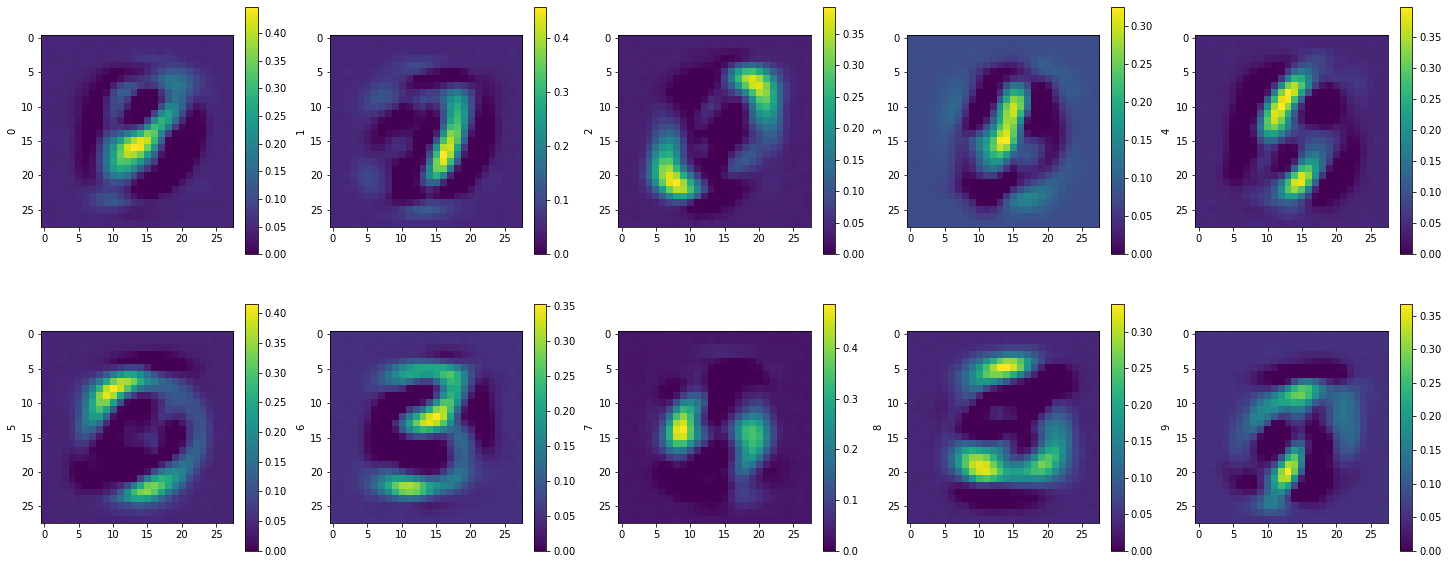

In [808]:
#visualise first 10 components
nrow = 2; ncol = 5;
fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(25,10))
for i,ax in enumerate(axs.reshape(-1)): 
    im =ax.imshow(H[i,:].reshape([28,28]))
    ax.set_ylabel(str(i))
    fig.colorbar(im,ax=ax)

The top 10 NMF components look different to the top 10 PCA components. We can see values do not go below 0. The images are darker in the background and show different shapes than the PCA components. They are different because the algorithms used to find them make different assumptions about the structure of the data. NMF minimizes the distance between the original data and the reconstructed data, subject to the constraint that the basis vectors are non-negative, while PCA minimizes the variance of the data along the principal components.
Also, the scaling is different. NMF produces basis vectors that are normalized to have unit length, while PCA produces principal components that are scaled to have a variance of one. Due to the non-negativity assumption and the scaling, the NMF components background pixels are in constrast small compared to the pixels in the middle.

1.2.3

In [814]:
#we get the dataframes again so we have the unstandardised versions
train_noisy = pd.read_csv("train_noisy.txt",sep=" ",header=None)
test_noisy = pd.read_csv("test_noisy.txt",sep=" ",header=None)

In [815]:
def standardise(X):
    """standardisation for the PCA function"""
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar,mu,std_filled

In [816]:
def normalize_nmf(X):
    """normalisation function for NMF"""
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X)) 
    return X_norm,np.max(X),np.min(X)

In [817]:
#convert noisy data to matrices
images = train_noisy.to_numpy()
images_test = test_noisy.to_numpy()

I have adapted the standardisation function for PCA above to output the means and standard deviations of the training data. This allows us to standardise the test noisy data by the same amount. We want to do it so the test data is comparable to the training data as it has been scaled in the same way. Similarly, NMF normalisation function is adapted to output the minimum and the maximum so that the test data can be scaled in the same way. I will train the noisy data using m=100 for both PCA and NMF.

In [755]:
#standardise the test and training noisy images to use in PCA
images_PCA, mu, std_filled = standardise(images)
test_PCA = (images_test-mu)/std_filled

In [653]:
#normalise the images by the same factor in testing and training
images_NMF,maximum,minimum = normalize_nmf(images)
test_NMF = (images_test- minimum) / (maximum - minimum)

In [654]:
m=100
#do the PCA with m=100
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(images_PCA,m)

In [655]:
#do NMF with m=100
np.random.seed(0)

# k x P matrix interpreted as the basis set, where k is the number of components, P the number of descriptors of the data
H = np.random.rand(m, images_NMF.shape[1])

# N x k components matrix, usually interpreted as the coefficients, N is the number of data
W = np.random.rand(images_NMF.shape[0], m)
W_test = np.random.rand(test_NMF.shape[0], m)

# set the number of iterations
#we have tested that 500 iterations is more than enough
n_iters = 500
pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero

# empty list 
cost_values = []

# loop over the n iterations
for i in range(n_iters):

    # compute the update on H
    H = H * ((W.T.dot(images_NMF))/(W.T.dot(W.dot(H))+pseudo_count))

    # compute the update on W
    W = W * ((images_NMF.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count))
   # W_test = W_test * ((test_NMF.dot(H.T))/(W_test.dot(H.dot(H.T))+pseudo_count))

    # compute the cost and append to list
    cost_values.append(cost(images_NMF,W,H))

In [670]:
NMF = test_NMF@H.T@H

In [678]:
#undo the normalisation exactly with the opposite operations we standardised with
NMF = (maximum-minimum)*NMF+minimum

In order to reconstruct the images using PCA we must multiply the test PCA matrix by the eigenvector and again by their transpose.

The formula for transforming the test data matrix X_test using Principal Component Analysis is given by:

\begin{equation}
X_{pca} = X_{test}V V^T
\end{equation}
where $X_{test}$ is already standardised. The matrix multiplication $V V^T$ is equivalent to projecting the test data matrix onto the principal component subspace defined by the matrix V. The resulting transformed matrix $X_{pca}$ contains the scores of the test data samples in the new principal component space. Then we must undo the standardisation.

The formula for transforming the test data matrix X_test using NMF is given by:
\begin{equation}
X_{pca} = X_{test}H.T@ H
\end{equation}
where $X_{test}$ is already normalization. The matrix multiplication $H.T@ H$ is the analogue to what we use for PCA except that the components are stored in the rows. The resulting transformed matrix $X_{pca}$ contains the scores of the test data samples in the new space. Then we must undo the normalization.

In [679]:
PCA_pre = (test_PCA@eigenvectors@eigenvectors.T)
#multiply by standard deviation stored of the training and add mu to get the final reconstructed image
PCA = PCA_pre*std_filled+mu

In [680]:
#load the original non-noisy images
test = pd.read_csv("MNIST_test.csv")
test=test.to_numpy()[:,1:]

I will visualise the first image in every case, for the original , noisy, PCA reconstruction and NMF reconstruction.

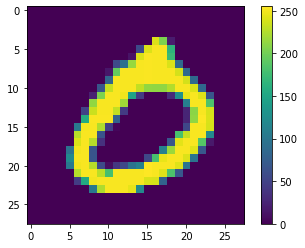

In [818]:
#show the orignal first images which is not noisy
plt.imshow(test[0].reshape(28,28));
plt.colorbar()

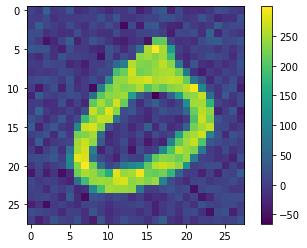

In [819]:
#show the noisy first image
plt.imshow(images_test[0].reshape(28,28));
plt.colorbar()

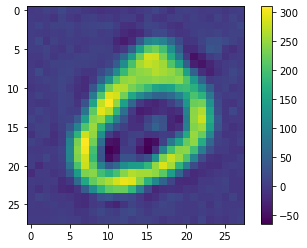

In [820]:
#reconstruction of the first image using PCA
plt.imshow(PCA[0].reshape(28,28));
plt.colorbar()

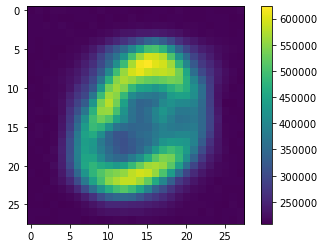

In [821]:
#reconstruction of the first image using NMF
plt.imshow(NMF[0].reshape(28,28));
plt.colorbar()

PCA has visibly denoised effectively as the background is now more uniform in colour than in the original image. However, we have not really reconstructed the original image which has a completely dark background, i.e. the colour scheme is altered. What has most likely happened is that the pixels have lost noise but in the steps where we standardise and then unstandardised we have not reconstructed exactly the same image. We probably are much closer to the image if we standardise both. It is also possible that we have removed some noise but not all so we have something with less noise but not lining up to the original as there is noise left.

NMF meanwhile denoises the background very effectively, getting a dark background like the original, i.e. has set most of the background to 0. Compared to PCA, it denoises the background more effectively but it loses some reconstruction value in the centre, where PCA has a clearer light ring in the middle and the ring for NMF is more blurry in some places.

1.2.4

I will plot on the same axes the MSE of the reconstructed images from PCA with the noisy image and the PCA with the original image.

In [756]:
def mse(X1, X2):
    """mean squared error function"""
    # Compute the element-wise squared difference between the two sets of images
    diff = (X1 - X2)**2
    # Calculate the mean squared error
    mean_squared_error = np.mean(diff)
    return mean_squared_error

In [757]:
def reverse_standardise(Xbar):
    """multiply by the standard deviation and add mu to unstandardise"""
    return Xbar*std_filled + mu

In [758]:
def PCA_denoise(images_PCA,test,m, unstandardise=False):
    """function that outputs reconstructs the image using PCA and outputs the MSE and the reconstruction"""
# compute the projection, the eigenvector and eigenvalues from our function
#to PCA with m components
    X_pca, eigenvectors, eigenvalues = pca_function(images_PCA,m)
    #get the unstandardised PCA reconstruction
    PCA = (test_PCA@eigenvectors@eigenvectors.T)
    #either unstandardise at the end or do not based on if unstandardise is True
    if unstandardise==True:
        PCA = reverse_standardise(PCA)
        test = reverse_standardise(test)
    #PCA = PCA*std_filled+mu
    return mse(PCA,test),PCA

In [759]:
#define a range of m values to iterate over up to 400
ms=np.arange(5,405,5)

In [760]:
#original data standardised
test_P = (test-mu)/std_filled

In [761]:
#noisy data standardised
images_test_P=(images_test-mu)/std_filled

In [777]:
#store the MSEs for the uncorrupted and corrupted with the reconstructions
MSE_uncorrupted=[]
MSE_corrupted=[]
for m in ms:
    MSE_uncorrupted.append(PCA_denoise(images_PCA,test_P,m)[0])
    MSE_corrupted.append(PCA_denoise(images_PCA,images_test_P,m)[0])

In [774]:
rescaled_MSE_uncorrupted=[]
rescaled_MSE_corrupted = []
for m in ms:
    rescaled_MSE_uncorrupted.append(PCA_denoise(images_PCA,test_P,m,unstandardise=True)[0])
    rescaled_MSE_corrupted.append(PCA_denoise(images_PCA,images_test_P,m,unstandardise=True)[0])

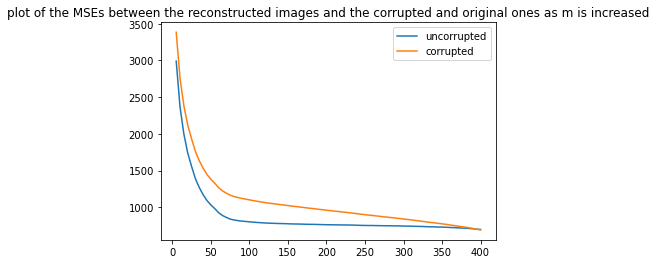

In [764]:
#plot the unstandardised images against each other
plt.plot(ms,rescaled_MSE_uncorrupted,label="uncorrupted")
plt.plot(ms,rescaled_MSE_corrupted,label="corrupted")
plt.legend()
plt.title("plot of the MSEs between the reconstructed images and the corrupted and original ones as m is increased")
plt.show()

As you increase m the MSE with the corrupted image decreases gradually until m=400 and seems to still be decreasing, which suggests we get closer to the corrupted image as we increase the total explained variance. The gap between the MSE with the corrupted and uncorrupted peaks at around 50. It is difficult to observe the trend on the unstandardised version of the images MSE calculation, perhaps as some directions dominate, so I will also plot the graph comparing the standardised versions.

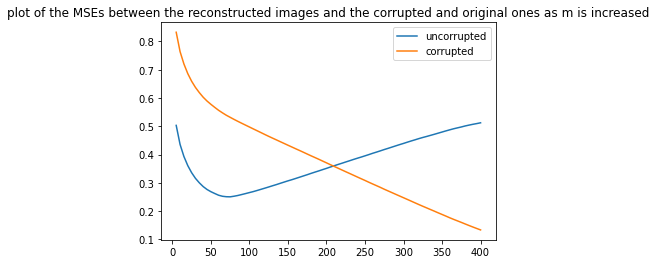

In [778]:
#MSEs when both standardised
plt.plot(ms,MSE_uncorrupted,label="uncorrupted")
plt.plot(ms,MSE_corrupted,label="corrupted")
plt.legend()
plt.title("plot of the MSEs between the reconstructed images and the corrupted and original ones as m is increased")
plt.show()

We can see from the various reconstructions of the first image as we increase m progressively that we progressively recover all the variance hence get  closer to the noisy image. The reconstruction with the lowest m=10 is closest to the original image. We can also see in the plot of the MSEs for the standardised cases that the MSE of the reconstructions with the corrupted image gradually decreases to 0 as you increase m, which is because you are gradually explaining more of the variance as you keep more principal components by increasing m. Meanwhile, the MSE curve of the reconstructions with the original uncorrupted images decreases until around m=50 where we hit an optimal number of components to reconstruct the original images well. As you increase m past this point, the MSE increases gradually, probably because the explained variance past the first 50 eigenvalues is just noise. Beyond around m=200, the images are closer to the corrupted images than the uncorrupted ones. The reason the blue curve first decreases is because when you remove principal values to have less than 50 we lose some of the information. We can indeed see in the plot of the first image with m=10 that the central bright ring becomes more blurry at m=10, and more and more clear as we increase m, though the noise of the background increases.

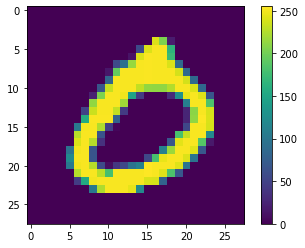

In [822]:
#show the original image
plt.imshow(test[0].reshape(28,28));
plt.colorbar()

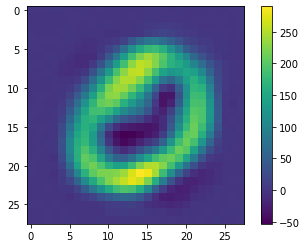

In [823]:
#show the reconstructed image for m=10
plt.imshow((PCA_denoise(images_PCA,test,10,unstandardise=True)[1][0]).reshape(28,28));
plt.colorbar()

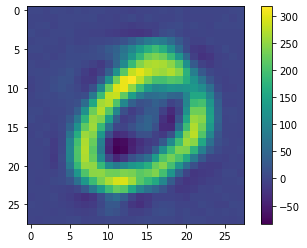

In [824]:
#m=40 case
plt.imshow((PCA_denoise(images_PCA,test,40,unstandardise=True)[1][0]).reshape(28,28));
plt.colorbar()

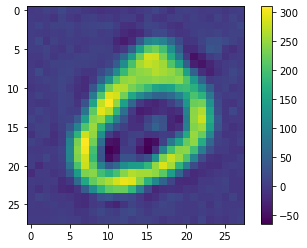

In [825]:
#m=100
plt.imshow((PCA_denoise(images_PCA,test,100,unstandardise=True)[1][0]).reshape(28,28));
plt.colorbar()

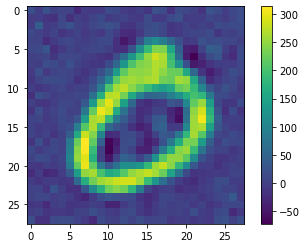

In [826]:
#m=200
plt.imshow((PCA_denoise(images_PCA,test,200,unstandardise=True)[1][0]).reshape(28,28));
plt.colorbar()

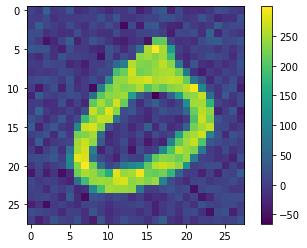

In [827]:
#full noisy image
plt.imshow(images_test[0].reshape(28,28));
plt.colorbar()

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

I will do PCA on the training data set to find the first 5 principal components and do clustering with a GMM model with 10 hidden components. There are 10 possible labels so this intuitively makes sense.

In [855]:
#I reload the training data
training = pd.read_csv("MNIST_train.csv")

In [856]:
#training is my X variable
training = training.to_numpy()[:1000,1:]

In [857]:
#I get y as the labels but do not one-hot encode
y_train = train["label"].to_numpy()

In [858]:
def standardise(X):
    """standardisation of the data required for PCA"""
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [859]:
#standardise the training data
training_standard = standardise(training)

In [860]:
#perform PCA and get the first 5 components
X_pca, eigenvectors, eigenvalues=pca_function(training_standard,5)

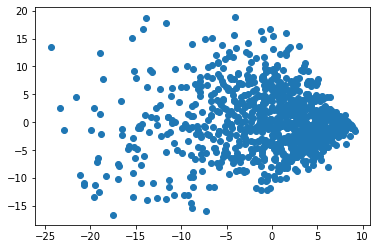

In [861]:
#scatter plot of the locations of the first 2 principal components
plt.scatter(X_pca[:,0],X_pca[:,1])

The GMM estimates the parameters of the mixture model (the weights, means, and covariances) from the data using an iterative EM algorithm. The EM algorithm alternates between two steps:
1. computing the posterior probability of each data point for each Gaussian component, based on the current estimates of the parameters.
2. updating the parameters of each Gaussian component based on the posterior probabilities computed in 1.

The EM algorithm iterates between these two steps until convergence, where I will define convergence as the change in log likelihood of the whole model between 2 iterations being below a threshold.

In [862]:
class GMModel:
    """Gaussian Mixture Model function"""
    def __init__(self, X, dim):
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 

In [863]:
#import relevant library
from scipy.stats import multivariate_normal 

In [864]:
def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) ### <- fill in
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

In [865]:
def predict(gmm, X):
    """uses the argmax of the weights to make a prediction"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1)

In [866]:
def plot_gmm(gmm, X, label=True, ax=None):
    """plot the gaussian mixture model"""
    ax = ax or plt.gca()
    labels = predict(gmm,X)
    if label:
        scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
        #create a legend showing the clusters
        ax.legend(*scatter.legend_elements(), title='Cluster')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    w_factor = 0.2 / gmm.weights.max()
    return ax

In [867]:
def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X) ### <- fill in
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

The graph below shows how the data points have been assigned to 10 clusters and visualise the first 2 principal components of these.

-2232.883989809452


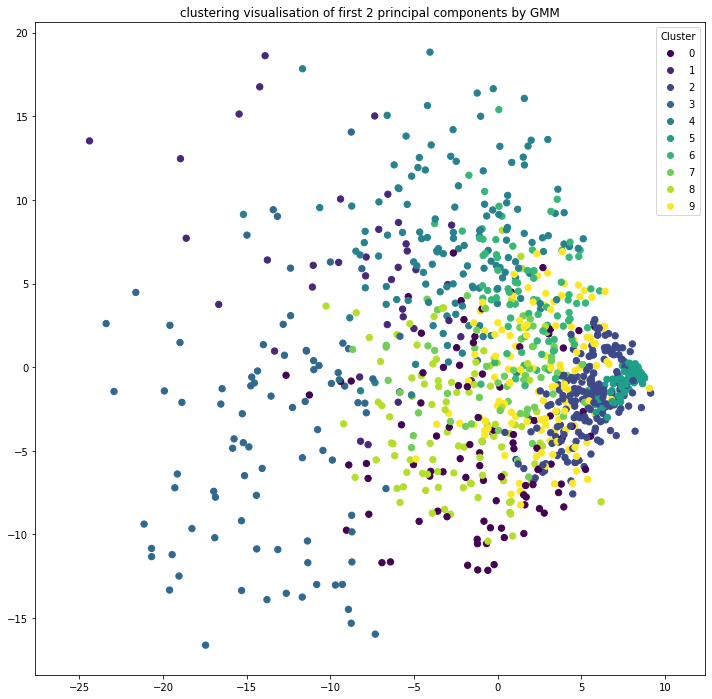

In [868]:
#run the GMM model
plt.figure(figsize=(12,12))
plt.title("clustering visualisation of first 2 principal components by GMM")
np.random.seed(4)
gmm = GMModel(X_pca,10)
criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
#fit the model
fitStep(gmm,X_pca)
#calculate the log likelihood of the whole model
new_criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
#iterate until the change is negligeable meaning the model parameters have converged
while (abs(new_criterion-criterion))>1e-8:
    fitStep(gmm,X_pca)
    criterion = new_criterion
    new_criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
    
plot_gmm(gmm,X_pca)
print(new_criterion)

It seems that the clusters are not really separated, however we are only visualising the first 2 principal components, hence the clusters may be separated if visualised in further dimensions and this graph is squashed.

1.3.2

In [869]:
import matplotlib.pyplot as plt

def plot_class_labels(X, y, label=True, ax=None):
    """function to plot the map according to the true class labels"""
    plt.figure(figsize=(12,12))
    plt.title("visualise first 2 components coloured by class label")
    ax = ax or plt.gca()
    labels = y_train[:1000]
    if label:
        # Plot data points with colored markers and labels
        scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
        ax.legend(*scatter.legend_elements(), title='Classes')
    else:
        # Plot data points with uncolored markers and no labels
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    return ax

In [870]:
#the class labels
y=["0","1","2","3","4","5","6","7","8","9"]

The graph below shows the points with colours according to their true labels visualised in 2D.

<AxesSubplot:title={'center':'visualise first 2 components coloured by class label'}>

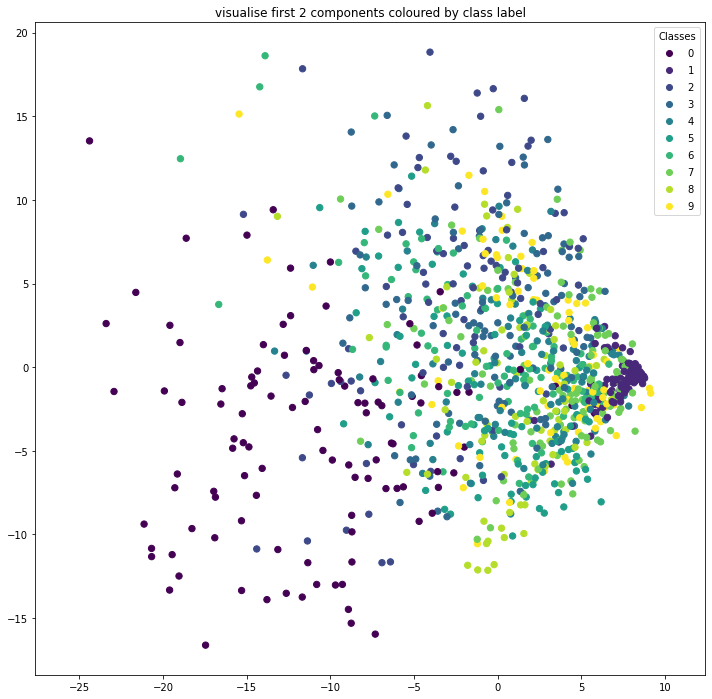

In [871]:
plot_class_labels(X_pca[:, :2],y)

We can see that for one of the darker labels, the cluster is further out in the space visible to us and more spread out compared to the other labels, one which quite a few are visibly bunched up near (-10,0).

I show below for each cluster index how many elements have been assigned to that cluster. We can already see an imbalance.

In [872]:
clusters = predict(gmm,X_pca)
counts_cluster={}
for cluster in np.unique(clusters):
    counts_cluster[cluster]=len(clusters[clusters==cluster])
print(counts_cluster)

{0: 97, 1: 38, 2: 180, 3: 88, 4: 135, 5: 85, 6: 86, 7: 62, 8: 103, 9: 126}


In [873]:
 def log_likelihood(gmm, X):
    """function that computes the log likelihood of the clusters in the model"""
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape
    # Creates a n*k matrix denoting likelihood belonging to each cluster  
    log_probs = np.zeros((n, gmm.dim))
    for i in range(gmm.dim):
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) # create the multivariate distribution
        log_probs[:,i] = distribution.logpdf(X) # take the log pdf
    return log_probs

I iterate through every label and for each label find the data points corresponding to that label, and work out the log likelihood for this subset, assigning the log probability for each cluster and label as the sum across log probabilities for every datapoint with this label. I also create a map which maps every labels to the index or cluster with the largest sum of log likelihoods, i.e. the best-fitting cluster index where log-likelihood is used as the measure of fit quality.

In [874]:
#iterate over the labels and for each one
#create a matrix with all the probabilities
#create a dictionary with the probabilities for each cluster as the values and labels as keys
#create a map which has the cluster that each label is assigned to most
probs_matrix = []
cluster_probs = {}
cluster_map = {}
labels = y_train[:1000]
for label in np.unique(labels):
    data = X_pca[labels==label]
    log_probs = log_likelihood(gmm,data)
    cluster_probs[label] = np.sum(log_probs,axis=0)
    probs_matrix.append(np.sum(log_probs,axis=0))
    cluster_map[label]=np.argmax(np.sum(log_probs,axis=0))
    
print(cluster_probs)
print(cluster_map)

{0: array([  -3448.84972897,   -2551.474468  ,  -20497.15766157,
         -1581.51637356,   -3558.45130783, -106547.43824831,
        -10089.30367612,   -6186.69346291,   -2837.34000785,
        -17363.34245787]), 1: array([-1459.12562377, -2010.04697272, -1257.42156948, -2475.86752816,
       -1959.78493826, -1012.97514385, -2178.84670248, -1979.21620065,
       -2764.57953607, -1401.47391282]), 2: array([ -1905.29015844,  -2381.51953458,  -9011.57492328,  -2258.22869609,
        -1682.86226387, -70101.89999427,  -3725.86087205,  -4935.51066281,
        -4048.97907113,  -6453.16759989]), 3: array([ -3383.97035385,  -3664.59762424, -12394.71507834,  -2099.96464639,
        -1746.12177815, -54183.21853223,  -5281.08804187,  -3921.94026805,
        -2471.5892524 ,  -2840.81773749]), 4: array([ -1985.57780029,  -1541.46260285,  -2418.17065314,  -2661.81088783,
        -1778.93037253, -26409.78576089,  -1546.7818584 ,  -3169.8771345 ,
        -1594.83254412,  -4238.82609326]), 5: array([ -

Several labels  have best fit with the same cluster. For example multiple labels have been assigned to the cluster 4, and certain cluster have nom labels assigned to it. This shows that our class-cluster map is not a bijection, i.e. is not doing a perfect job of clustering according to the actual labels. It is perhaps less surprising to see that the map assigns several labels to cluster 4 considering that cluster 4 is the largest in size.

1.3.3

For each label, the set of points within that label have each been assigned a cluster. For each label, I will plot the points within that label, coloured according to the cluster probability of the cluster it has been assigned to.

In [875]:
def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) ### <- fill in
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
    return weights

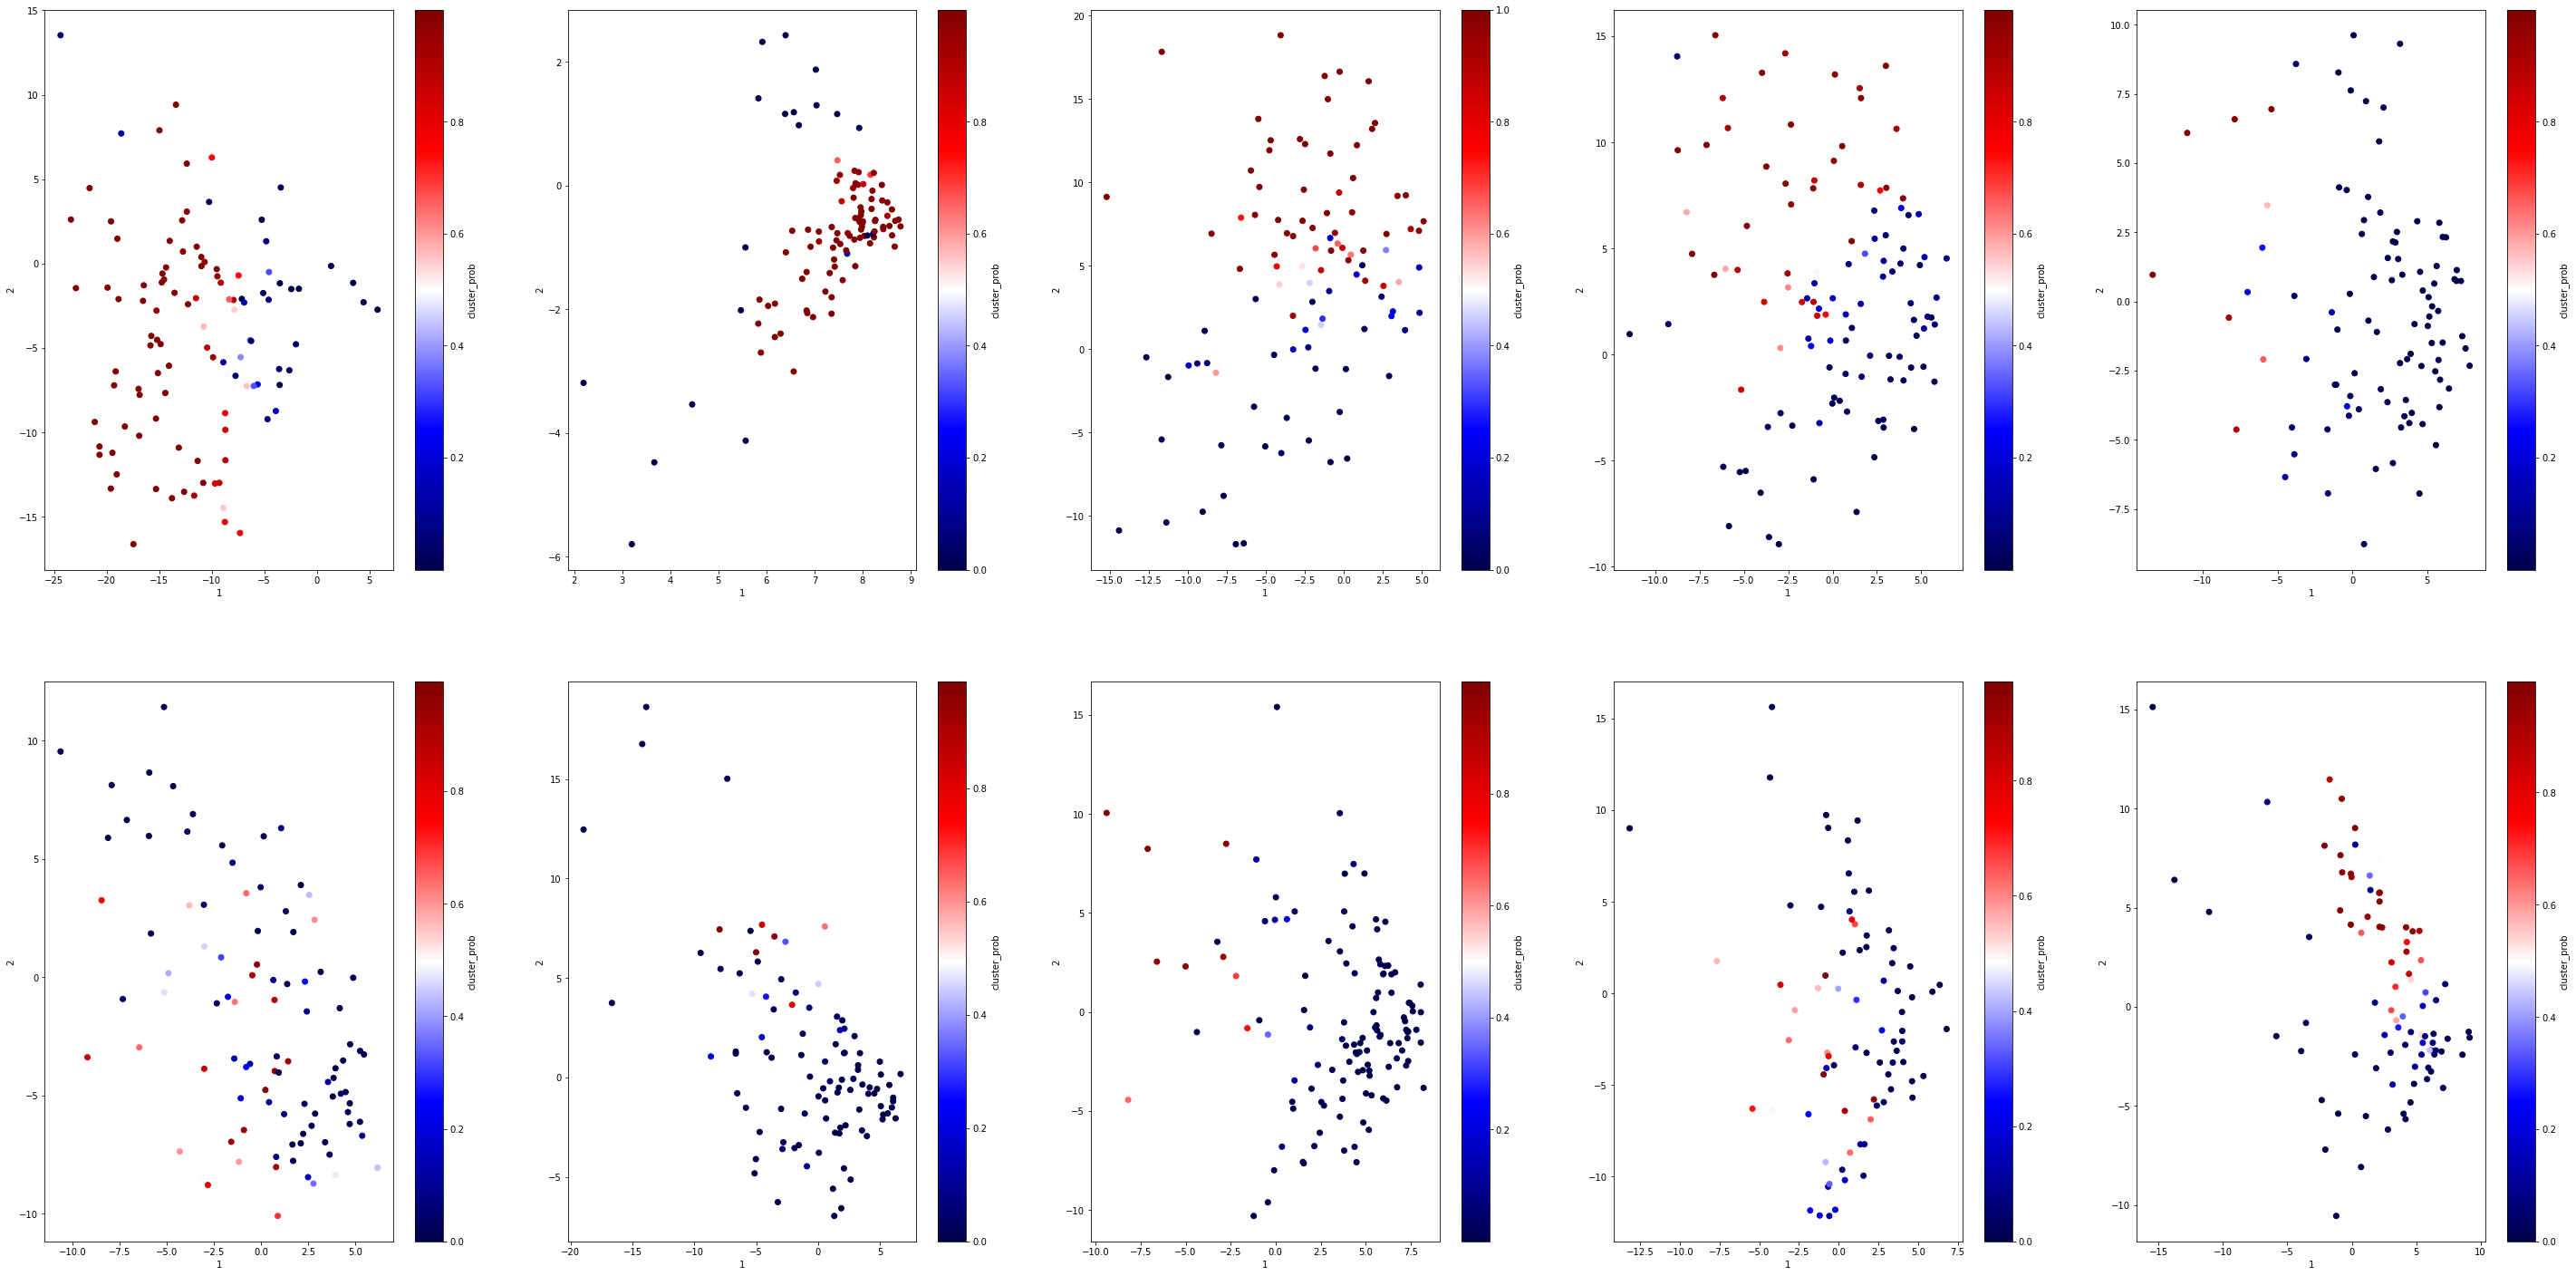

In [880]:
from matplotlib.cm import ScalarMappable
plt.figure(figsize =(50,25))
for i,c in enumerate(np.arange(10)):
    plt.subplot(2,5,i+1)
    # find the points corresponding to each label
    points = X_pca[labels==c]
    all_probs = cluster_probabilities(gmm,points)
    p = all_probs[:,cluster_map[c]]   
    cmap = plt.cm.get_cmap('seismic')
    scale = plt.Normalize(vmin=p.min(), vmax=p.max())
    sm = ScalarMappable(norm=scale, cmap=cmap)
    colors = cmap(p)
    plt.scatter(points[:,0],points[:,1],c=sm.to_rgba(p))
    plt.xlabel('1')
    plt.ylabel('2')    
    colorb = plt.colorbar(sm)
    colorb.set_label('cluster_prob')

For some of the labels such as the label 0, the clustering probability of many of the points is high, meaning that the cluster that that point was assigned to has a high cluster probability for that cluster, with a minority of the points having a lower cluster. However, for some of the labels, the probability for a lot of the points in that label is low.

Each data point is assigned a probability of belonging to each cluster based on its distance from the mean and the covariance matrix of each component, the posterior probabilities

The uncertainty of the clustering is measured by examining the posterior probabilities of each data point. If a data point has high posterior probabilities for only one cluster, then there is low uncertainty about its assignment to that cluster. If a data point has similar posterior probabilities for multiple clusters, then there is high uncertainty about its assignment. This is the case for the data points which have a low probability for the cluster which it was assigned to, which suggests they were almost equally likely to be assigned to several cluster. If for example, a point has probability 0.2 of being assigned to 5 different clusters, then even for the argmax the probability is low.

With label 6 for example, many of the points had a low probability of being assigned to whichever cluster they were assigned to. This suggests that points in label 6 were difficult to assign a probability to based of the distance to the meanand covariance, so perhaps multiple points were near several potential clusters. For points in 6, the cluster uncertainty is high.

Given many blue points, the clustering uncertainty overall must be high.

1.3.4

I repeat the tasks with 8 components.

-1982.730034381341


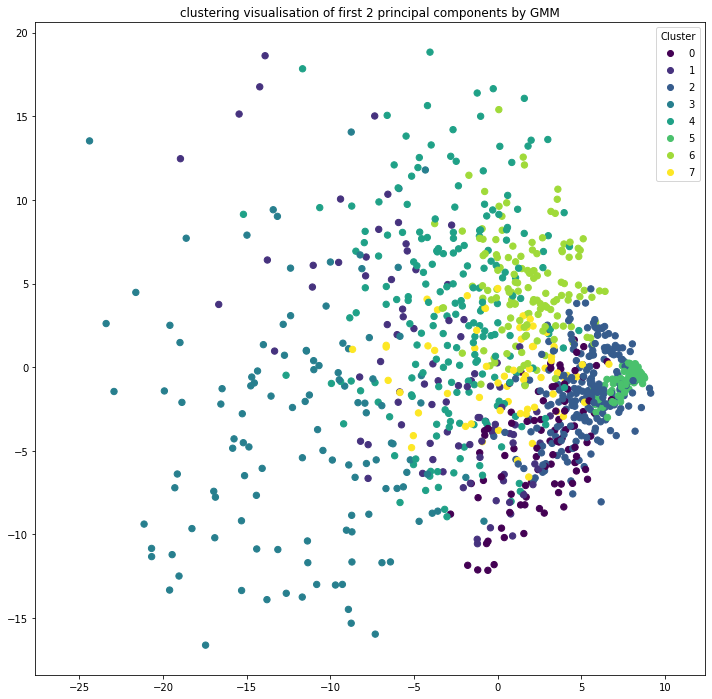

In [881]:
plt.figure(figsize=(12,12))
plt.title("clustering visualisation of first 2 principal components by GMM")
np.random.seed(4)
gmm = GMModel(X_pca,8)
criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
fitStep(gmm,X_pca)
new_criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
while (abs(new_criterion-criterion))>1e-8:
    #add convergence metric
    fitStep(gmm,X_pca)
    criterion = new_criterion
    new_criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
    
plot_gmm(gmm,X_pca)
print(new_criterion)

In [882]:
#iterate over the labels and for each one
#create a matrix with all the probabilities
#create a dictionary with the probabilities for each cluster as the values and labels as keys
#create a map which has the cluster that each label is assigned to most
probs_matrix = []
cluster_probs = {}
cluster_map = {}
labels = y_train[:1000]
for label in np.unique(labels):
    data = X_pca[labels==label]
    log_probs = log_likelihood(gmm,data)
    cluster_probs[label] = np.sum(log_probs,axis=0)
    probs_matrix.append(np.sum(log_probs,axis=0))
    cluster_map[label]=np.argmax(np.sum(log_probs,axis=0))
    
print(cluster_probs)
print(cluster_map)

{0: array([ -10855.16255365,   -3271.36102914,  -15731.04287408,
         -1549.95685777,   -2885.9019159 , -106757.89769382,
         -7685.48801673,   -6579.41369677]), 1: array([-1230.11524175, -1863.73764025, -1291.79686145, -2030.04041196,
       -1774.90866667, -1012.65252165, -1933.3717291 , -1869.97689091]), 2: array([ -6687.36418332,  -2424.39399991,  -6920.52676875,  -2052.31056177,
        -1542.27085345, -70366.3683587 ,  -2865.92383626,  -5137.80882326]), 3: array([ -5133.71593614,  -4156.61606303,  -9653.40328426,  -1982.74623673,
        -1677.71943921, -54180.82062752,  -2355.38125326,  -3938.91331561]), 4: array([ -3937.9160653 ,  -1439.66727435,  -1931.35913759,  -2168.81473465,
        -1686.94275343, -26395.73001678,  -1592.95532415,  -3390.12231472]), 5: array([ -2730.25617919,  -2227.55671364,  -4801.81132466,  -1616.46758363,
        -1484.97255468, -29572.31970058,  -2062.14788168,  -3107.87146757]), 6: array([ -7037.12873513,  -1852.29016716,  -4087.86562342,  

When we reduce the number of clusters, the map becomes even less of a bijection. 5 labels are all assigned to the same cluster with index 4. We can see how this has happened as 4 is a very large cluster which covers a lot of points in a quite central area of the space (at least visually in 2d).

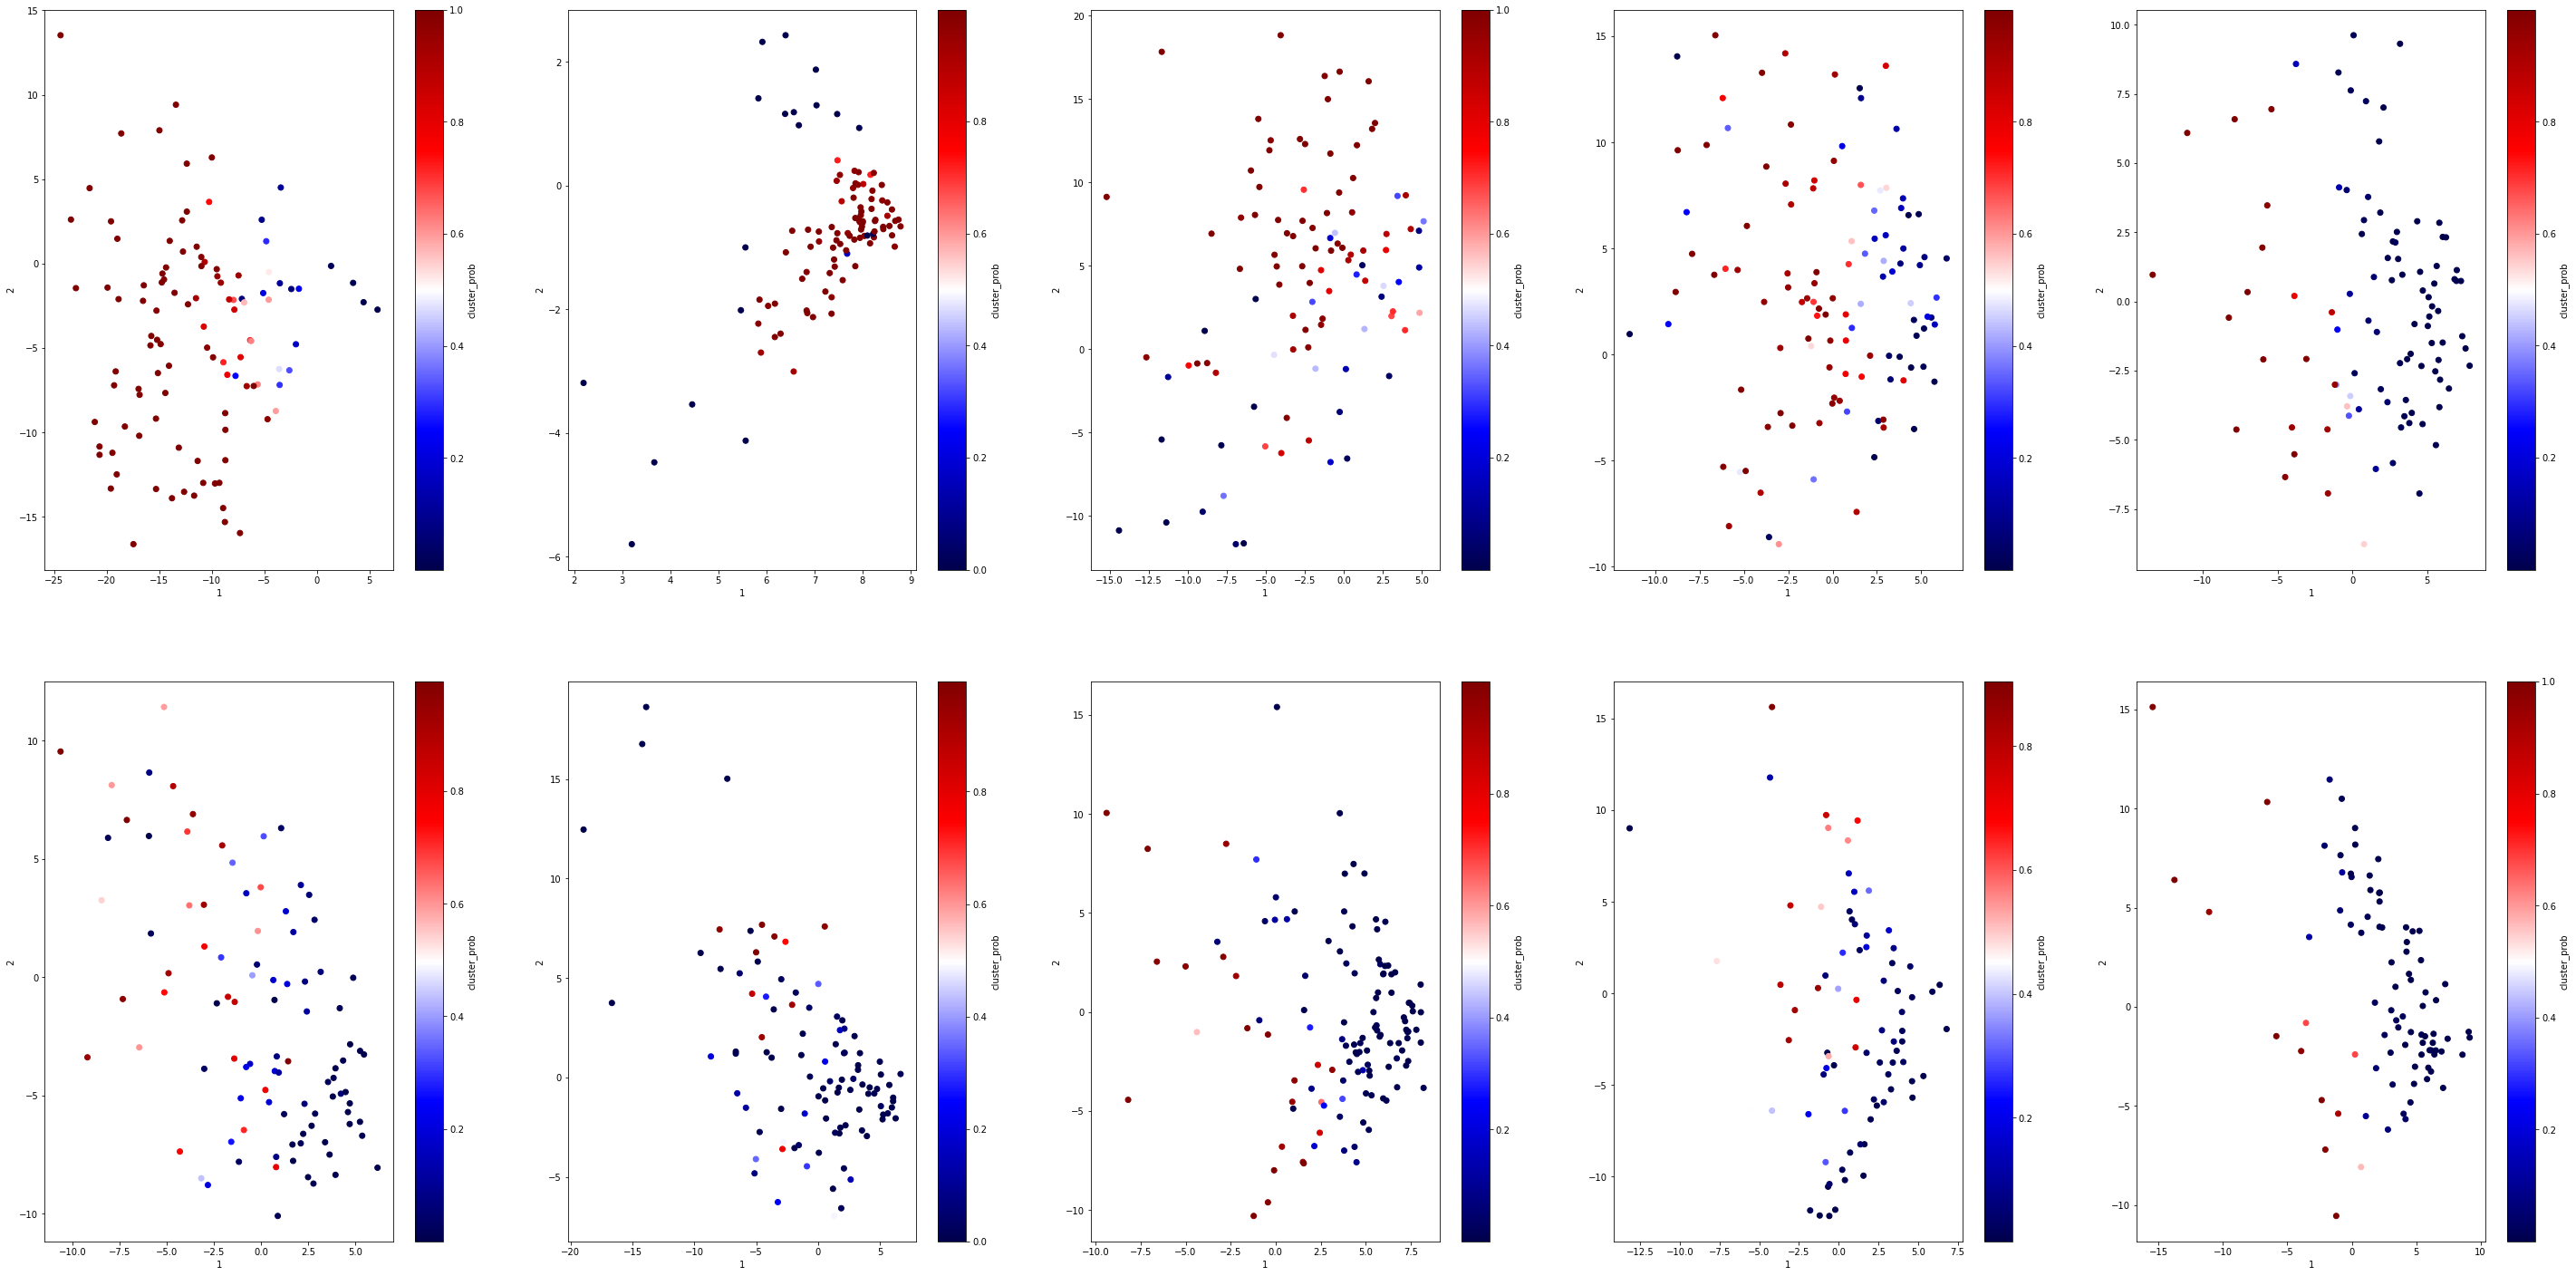

In [883]:
from matplotlib.cm import ScalarMappable
plt.figure(figsize =(50,25))
for i,c in enumerate(np.arange(10)):
    plt.subplot(2,5,i+1)
    # find the points corresponding to each label
    points = X_pca[labels==c]
    all_probs = cluster_probabilities(gmm,points)
    p = all_probs[:,cluster_map[c]]   
    cmap = plt.cm.get_cmap('seismic')
    scale = plt.Normalize(vmin=p.min(), vmax=p.max())
    sm = ScalarMappable(norm=scale, cmap=cmap)
    colors = cmap(p)
    plt.scatter(points[:,0],points[:,1],c=sm.to_rgba(p))
    plt.xlabel('1')
    plt.ylabel('2')    
    colorb = plt.colorbar(sm)
    colorb.set_label('cluster_prob')

I repeat the process with just 5 hidden components.

-1524.8645999771304


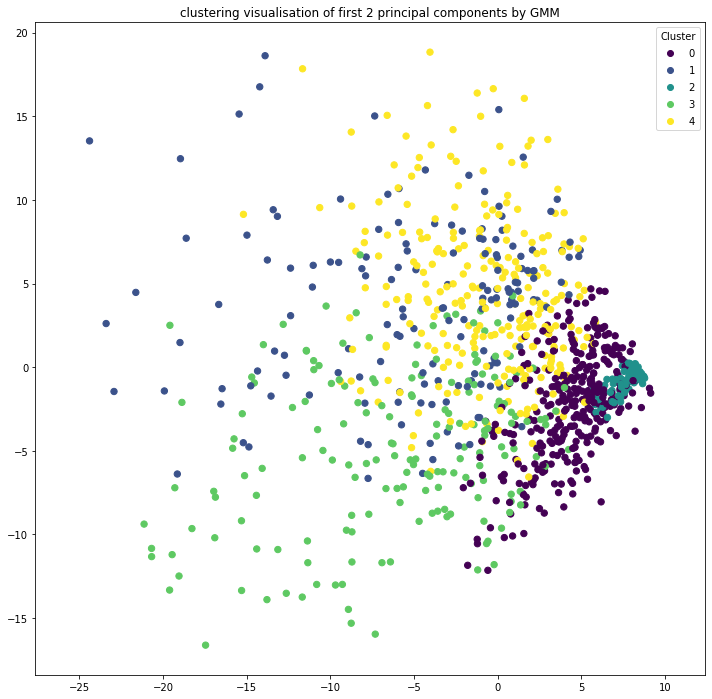

In [884]:
plt.figure(figsize=(12,12))
plt.title("clustering visualisation of first 2 principal components by GMM")
np.random.seed(4)
gmm = GMModel(X_pca,5)
criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
fitStep(gmm,X_pca)
new_criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
while (abs(new_criterion-criterion))>1e-8:
    #add convergence metric
    fitStep(gmm,X_pca)
    criterion = new_criterion
    new_criterion = np.sum(np.log(np.sum(cluster_probabilities(gmm,X_pca) * gmm.phi, axis=1)))
    
plot_gmm(gmm,X_pca)
print(new_criterion)

When there are fewer clusters, it is easier to see the separations in 2d than for 8 or even 10 clusters

5 clusters does not capture full complexity of class labels.

In [885]:
#iterate over the labels and for each one
#create a matrix with all the probabilities
#create a dictionary with the probabilities for each cluster as the values and labels as keys
#create a map which has the cluster that each label is assigned to most
probs_matrix = []
cluster_probs = {}
cluster_map = {}
labels = y_train[:1000]
for label in np.unique(labels):
    data = X_pca[labels==label]
    log_probs = log_likelihood(gmm,data)
    cluster_probs[label] = np.sum(log_probs,axis=0)
    probs_matrix.append(np.sum(log_probs,axis=0))
    cluster_map[label]=np.argmax(np.sum(log_probs,axis=0))
    
print(cluster_probs)
print(cluster_map)

{0: array([  -6901.01550087,   -1904.65031496, -106421.77399486,
         -1768.97786568,   -3738.43606078]), 1: array([-1260.73350436, -1834.88587894, -1005.4756356 , -1792.70143063,
       -1767.23028771]), 2: array([ -4553.23967825,  -1837.64399624, -70183.26248312,  -2252.56288955,
        -1701.70794975]), 3: array([ -4247.2508338 ,  -2324.01173374, -53731.02641242,  -1816.45573505,
        -1766.81377805]), 4: array([ -1683.24812464,  -1392.01069383, -26199.15620324,  -1880.19247242,
        -1747.24645352]), 5: array([ -2347.38839598,  -1702.68632273, -29324.7852982 ,  -1502.26553882,
        -1680.43771007]), 6: array([ -3389.42495379,  -1735.02800774, -47906.96202585,  -2118.30304775,
        -1580.88337431]), 7: array([ -1938.90836807,  -1885.97757187, -27012.6639466 ,  -2809.47616535,
        -2727.70722865]), 8: array([ -1621.68910077,  -1328.76385146, -21269.46987163,  -1179.24154599,
        -1366.64926369]), 9: array([ -1678.84046553,  -1255.40892505, -27763.45945027,  -

The fewer clusters we have the most often labels are assigned to the same cluster. In fact, 3 labels are assigned to the clusters 1 and 3 each.

In [514]:
#basically plotting how certain you are of that cluster when you assign something to a cluster, based off how likely that
#cluster is for that label

In [515]:
#maybe with fewer cluster you cannot have a 1-to-1 match of classes to clusters, but also fewer clusters any point can be 
#assigned to

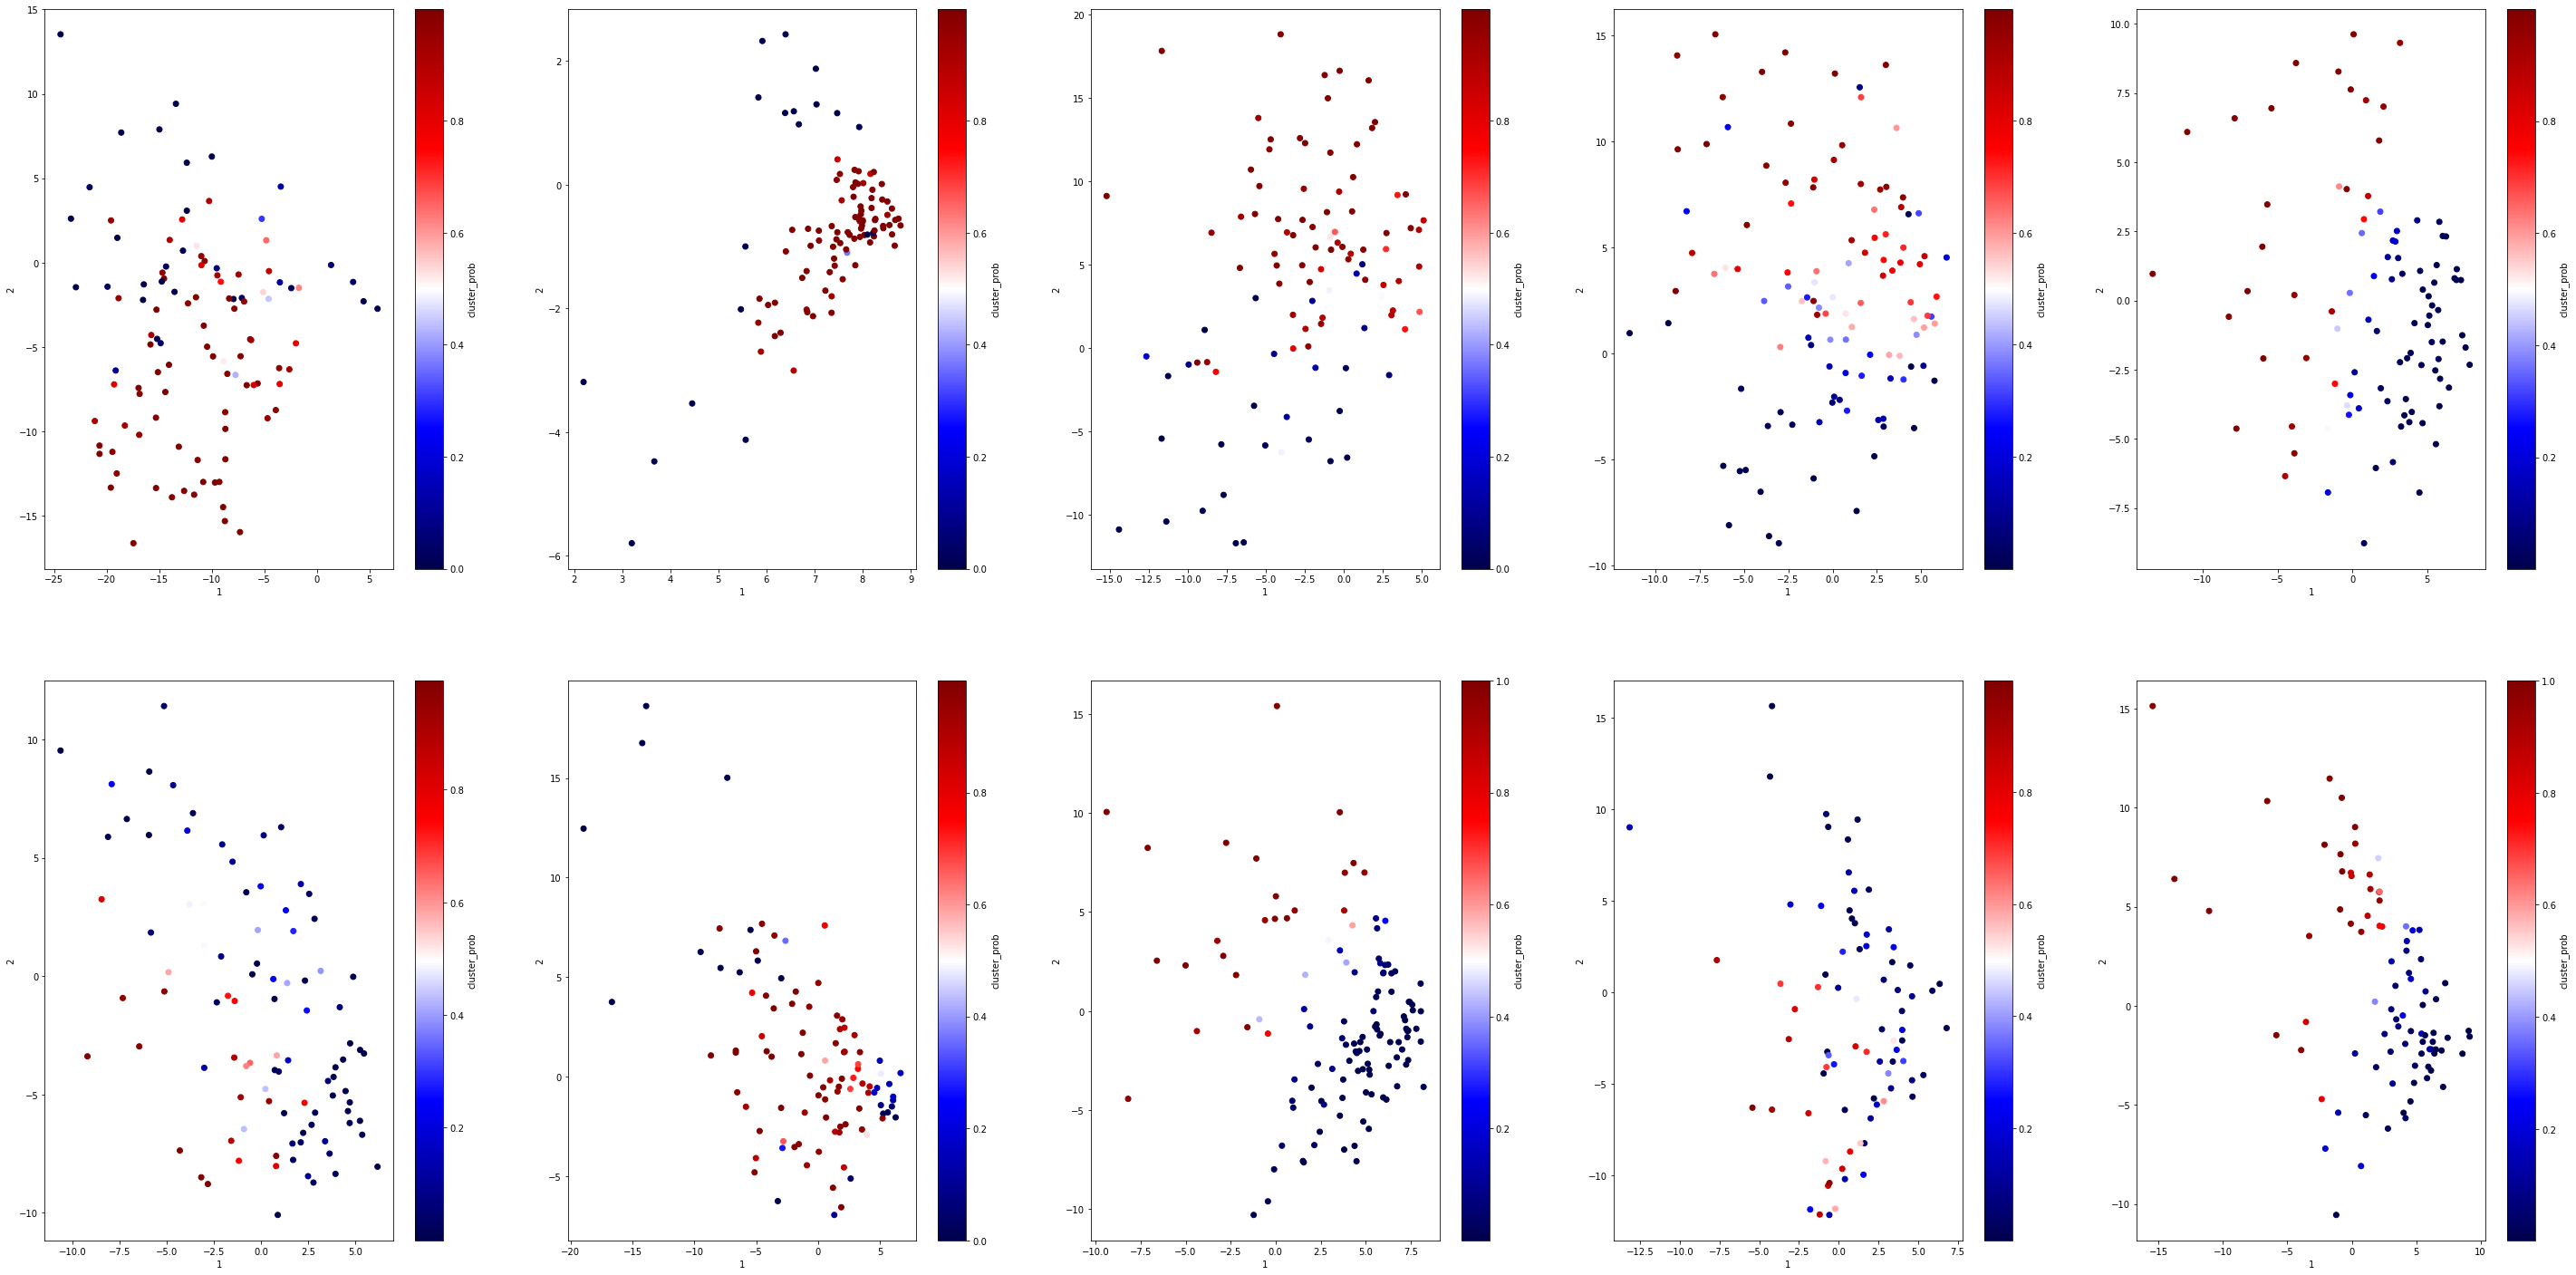

In [886]:
from matplotlib.cm import ScalarMappable
plt.figure(figsize =(50,25))
for i,c in enumerate(np.arange(10)):
    plt.subplot(2,5,i+1)
    # find the points corresponding to each label
    points = X_pca[labels==c]
    all_probs = cluster_probabilities(gmm,points)
    p = all_probs[:,cluster_map[c]]   
    cmap = plt.cm.get_cmap('seismic')
    scale = plt.Normalize(vmin=p.min(), vmax=p.max())
    sm = ScalarMappable(norm=scale, cmap=cmap)
    colors = cmap(p)
    plt.scatter(points[:,0],points[:,1],c=sm.to_rgba(p))
    plt.xlabel('1')
    plt.ylabel('2')    
    colorb = plt.colorbar(sm)
    colorb.set_label('cluster_prob')

The clustering probabilities seem to be higher when there are 5 clusters than when there are 10, and with 8 clusters it seems somewhere in the middle. It seems that when there are just 5 clusters, the cluster probabilties have potential to be higher on average as the model has fewer possibilities of assignment of each datapoint and although with fewer clusters it may be difficult to split the space well. At least as seen for the first 2 principal components, some of the clusters overlap quite a bit, perhaps as there are fewer clusters, hence the probabilities may be close between clusters. Nonetheless, it seems that overall the clustering uncertainty is bigger for the larger number of clusters, though the uncertainty is label dependent. In all cases, label 1 has points with very high certainty, for example.

### Task 2: Clustering and graph-based analysis (35 marks)

#### 2.1 Clustering (15 marks)
2.1.1

I run kmeans with different values of k and evaluate each model using the Kalinski-Harabasz index for each, average over 5 different initialisations. It measure clustering quality based on a ratio of the between-cluster scatter matrix, and the within-cluster scatter matrix. From the highest index, I will choose my optimal k to retrain the model using kmeans.

In [186]:
#read in the gene expression data
genes = pd.read_csv("gene_expression_data.csv")

In [187]:
#visualise the top of the dataframe
genes.head()

,Gene 0,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,...,Gene 86,Gene 87,Gene 88,Gene 89,Gene 90,Gene 91,Gene 92,Gene 93,Gene 94,Type
0,9.796088,0.591871,0.591871,0.000000,11.420571,13.453759,4.411847,5.412334,10.771613,10.225665,...,5.974369,8.086513,12.727750,15.205717,6.438116,6.412577,0.000000,6.814730,13.618145,PRAD
1,10.070470,0.000000,0.000000,0.000000,13.085672,14.531863,10.462298,9.832926,13.520312,13.968046,...,0.000000,0.000000,11.197204,12.993933,10.800746,10.749811,0.000000,11.445610,0.000000,LUAD
2,8.970920,0.000000,0.452595,0.000000,8.263119,9.754908,8.964549,9.948113,8.693773,8.776111,...,3.907160,5.324101,11.487066,13.380596,6.656236,10.209734,0.000000,7.748830,12.759976,PRAD
3,8.524616,1.039419,0.434882,0.000000,10.798520,12.263020,7.440695,8.062343,8.802083,9.237487,...,4.296083,6.959747,12.974639,14.891812,6.030725,7.315648,0.434882,7.117924,12.353276,PRAD
4,8.047238,0.000000,0.000000,0.360982,12.283010,14.033759,8.719180,8.831472,8.462073,8.211202,...,0.000000,0.000000,11.337237,13.390061,5.989593,8.359671,0.000000,6.327545,0.000000,BRCA


In [188]:
#create an X matrix of just the gene expression, dropping the type of the genes
X = genes.drop(columns = ["Type"]).to_numpy()

We standardise by the mean of each column so that the rows are all comparable, i.e. different genes.

In [189]:
def standardize_data(data):
    """function to standardise data by the mean and standard deviation of its columns"""
    # Calculate mean and standard deviation of each column
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    # Standardize data
    data_standardized = (data - means) / stds

    return data_standardized

In [190]:
#standardise the gene expression data
X=standardize_data(X)

In [112]:
#store the type of the genes to later evaluate the kmeans model
y = genes["Type"].to_numpy()

In [115]:
#we first initialise random type labels to the matrix ranging up to the value k
k=3
np.random.seed(12)
n_samples, n_features = X.shape
labels = np.random.randint(low=0, high=k, size=n_samples)
X_labels = np.append(X, labels.reshape(-1,1), axis=1)


The Calinski-Harabasz index is given by:
\begin{equation*}
\text{CH}(k) = \frac{\text{SSB}(k)/(k-1)}{\text{SSW}(k)/(n-k)},
\end{equation*}
where
\begin{align*}
\text{SSB}(k) &= \sum_{j=1}^k n_j(\bar{x}_j - \bar{x})^2, \\
\text{SSW}(k) &= \sum_{j=1}^k \sum_{i=1}^{n_j} (x_{ij} - \bar{x}_j)^2, \\
\bar{x}_j &= \frac{1}{n_j} \sum_{i=1}^{n_j} x_{ij}, \\
\bar{x} &= \frac{1}{n} \sum_{j=1}^k \sum_{i=1}^{n_j} x_{ij}.
\end{align*}
Here, $k$ is the number of clusters, $n$ is the total number of data points, $n_j$ is the number of data points in cluster $j$, $x_{ij}$ is the $i$th data point in cluster $j$, and $\bar{x}_j$ and $\bar{x}$ are the mean of cluster $j$ and the overall mean, respectively.


In [543]:
def calinski_harabasz(X_labels, k):
    """calculates the calinski-harabasz index"""
    
    def distance(xi,xj):
        """euclidean distance between xi and xj"""
        return np.linalg.norm(xi-xj)
    
    #the centroids are calculated as the mean of the values of x such that x is labeled as a certain value
    #hence each cluster has a centroid
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x[0:n_features] for x in X_labels if x[-1]==i], axis=0)
    total_centroid = np.mean(X_labels,axis=0)[0:n_features]
    
    #the clusters are defined as the points labeled as a certain type
    clusters =[]
    for i in range(k):
        cluster = np.array([x[0:n_features] for x in X_labels if x[-1]==i])
        clusters.append(cluster)
    
    #BCSM is a measure of clustering quality for the between-cluster scatter matrix
    BCSM = sum(len(clusters[k])*distance(centroids[k],total_centroid)**2 for k in range(k))
    print(BCSM)
    #within-cluster scatter matrix
    WCSM = np.sum([np.sum([distance(xi,centroids[k])**2 for xi in clusters[k]]) for k in range(k)])
    print(WCSM)
    n = n_samples
    #the index is a scaled ratio
    CH = (BCSM/(k-1))*((n-k)/WCSM)
    return CH

In [117]:
#arbitrarily set k to 3 to test the function above
k = 3
calinski_harabasz(X_labels, k)

386.8468840168809
75613.15311598312


2.038778663869011

I will either make a maximum of 30 iterations of kmeans or break out of the loop if the % change in labels is small.

Kmeans works by assigning centroids to the data, then assigning points to their closest centroid, recomputing the centroids based on the mean of the points assigned to each centroid, and iterating until points are hardlly relabeled within an iteration or not at all.

In [569]:
#iterate of k between 2 and 21 and store the average C-H index obtained from 5 runs of the kmeans algorithm
#for each value of k
max_iter = 30
k_values = np.arange(2,21)
ch_averages = []

for k in k_values:
    print("k= ",k)
    ch_sum = 0
    for seed in np.arange(5):
        print("seed= ",seed)
        difference = 0
        np.random.seed(seed+1)
        labels = np.random.randint(low=0, high=k, size=n_samples)
        X_labels = np.append(X, labels.reshape(-1,1), axis=1)
        centroids = np.zeros((k, n_features))
        for i in range(k):
            centroids[i] = np.mean([x[0:n_features] for x in X_labels if x[-1]==i], axis=0)
        # k-means algorithm
        for i in range(max_iter):
            print('Iteration:', i)
            # distances: between data points and centroids
            distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
            # new_labels: computed by finding centroid with minimal distance
            new_labels = np.argmin(distances, axis=0)

            if (labels==new_labels).all():
                # labels unchanged
                labels = new_labels
                print('Labels unchanged! Terminating k-means.')
                break
            else:
                # labels changed
                # difference: percentage of changed labels
                difference = np.mean(labels!=new_labels)
                print('%4f%% labels changed' % (difference * 100))
                labels = new_labels
                for c in range(k):
                    # update centroids by taking the mean over associated data points
                    if (labels == c).any():
                        centroids[c] = np.mean(X[labels==c], axis=0)
        X_labels = np.append(X, labels.reshape(-1,1), axis=1)
        ch = calinski_harabasz(X_labels, k)
        ch_sum += ch
    ch_average = ch_sum/5
    ch_averages.append(ch_average)
#display the value of k, the seed being run and the % change of the labels at each iteration

k=  2
seed=  0
Iteration: 0
44.875000% labels changed
Iteration: 1
21.250000% labels changed
Iteration: 2
6.875000% labels changed
Iteration: 3
2.125000% labels changed
Iteration: 4
0.750000% labels changed
Iteration: 5
0.375000% labels changed
Iteration: 6
Labels unchanged! Terminating k-means.
16306.486626283946
59693.51337371606
seed=  1
Iteration: 0
46.000000% labels changed
Iteration: 1
10.750000% labels changed
Iteration: 2
4.250000% labels changed
Iteration: 3
2.250000% labels changed
Iteration: 4
1.625000% labels changed
Iteration: 5
0.500000% labels changed
Iteration: 6
0.500000% labels changed
Iteration: 7
0.375000% labels changed
Iteration: 8
0.125000% labels changed
Iteration: 9
Labels unchanged! Terminating k-means.
14593.390619292808
61406.60938070719
seed=  2
Iteration: 0
47.375000% labels changed
Iteration: 1
7.000000% labels changed
Iteration: 2
2.125000% labels changed
Iteration: 3
0.375000% labels changed
Iteration: 4
Labels unchanged! Terminating k-means.
16306.4866

Text(0, 0.5, 'C-H index')

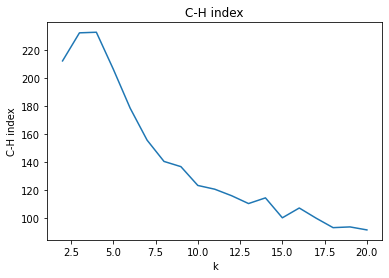

In [574]:
#plot of the average index as it changes with k
plt.plot(np.arange(2,21),ch_averages)
plt.title("C-H index")
plt.xlabel("k")
plt.ylabel("C-H index")

The curve increases in index from 2 till 4 and then the value slowly decreases as k is increased. This means according to the index k=4 is the best way to cluster. Intuitively, this means that for k=4 the clusters and well separated from each other and compact within each other and the ratio of those 2 metrics is high.

I retrain with the optimal k=4 and 5 different seeds and in each case look at the size of the clusters.

In [575]:
k=4
max_iter = 30
for seed in [1,3,5,7,9]:
    difference = 0
    np.random.seed(seed)
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x[0:n_features] for x in X_labels if x[-1]==i], axis=0)
            # k-means algorithm
    for i in range(max_iter):
        #print('Iteration:', i)
                # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
                # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
                    # labels unchanged
            labels = new_labels
            #print('Labels unchanged! Terminating k-means.')
            break
        else:
                    # labels changed
                    # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            #print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                        # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    print([np.sum(labels==c) for c in range(k)])

[346, 175, 138, 141]
[138, 328, 141, 193]
[219, 137, 303, 141]
[141, 135, 220, 304]
[141, 303, 221, 135]


Though the size of the clusters is slightly different each time, we see that they are roughly consistent. The order does not matter as this is an unsupervised task and so the clusters can be arbitrarily assigned a different label each time. We always get one of the clusters with size above 300, two with size below 200 and one cluster around 200, in size. Hence the clusters are certaintly not of equal size.

2.1.2

I will calculate the homogeneity score to assess the consistency of the cluster labels obtained with the types of the actual initial data.

I also first calculate the homegeneity score using 5 clusters for kmeans which we know is the actual number of types of gene.

In [577]:
#run kmeans with k=5 also
k=5
max_iter = 30
difference = 0
np.random.seed(1)
labels = np.random.randint(low=0, high=k, size=n_samples)
X_labels = np.append(X, labels.reshape(-1,1), axis=1)
centroids = np.zeros((k, n_features))
for i in range(k):
    centroids[i] = np.mean([x[0:n_features] for x in X_labels if x[-1]==i], axis=0)
            # k-means algorithm
for i in range(max_iter):
        #print('Iteration:', i)
                # distances: between data points and centroids
    distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
                # new_labels: computed by finding centroid with minimal distance
    new_labels = np.argmin(distances, axis=0)

    if (labels==new_labels).all():
                    # labels unchanged
        labels = new_labels
            #print('Labels unchanged! Terminating k-means.')
        break
    else:
                    # labels changed
                    # difference: percentage of changed labels
        difference = np.mean(labels!=new_labels)
            #print('%4f%% labels changed' % (difference * 100))
        labels = new_labels
        for c in range(k):
                        # update centroids by taking the mean over associated data points
            if (labels == c).any():
                centroids[c] = np.mean(X[labels==c], axis=0)
X_labels = np.append(X, labels.reshape(-1,1), axis=1)

The homogeneity score is defined as:
\begin{equation*}
H = 1 - \frac{H(C|K)}{H(C)},
\end{equation*}
where $H(C|K)$ is the conditional entropy of the true classes given the predicted clusters, and $H(C)$ is the entropy of the true classes.


It is easiest to first work out a matrix which has the number of genes assigned to each label which belongs to each class.

In [546]:
def homogeneity(labels, classes,k):
    """function to calculate the homogeneity score between the labels and the classes"""
    N = len(labels)
    A = np.zeros((5,k))
    #create a class-cluster map matrix
    for i,c in enumerate(classes):
        for label in range(k):
            if labels[i] == label:
                if c=="PRAD":
                    A[0, label]+=1
                elif c=="LUAD":
                    A[1,label]+=1
                elif c=="BRCA":
                    A[2,label]+=1
                elif c=="KIRC":
                    A[3,label]+=1
                else:
                    A[4,label]+=1
    #create a scaled matrix                
    B = np.zeros((5,k))
    for i in range(len(A)):
        for j in range(len(A[i])):
            if A[i][j] !=0:
                B[i][j]= np.log(A[i][j]/np.sum(A,axis=0)[j])
    #entropy of the classes given the predicted clusters
    hck = -np.sum(B*(A/N))
    #entropy of the true classes
    hc = -np.sum((np.sum(A,axis=1)/N)*np.log(np.sum(A,axis=1)/N))
    score = 1-hck/hc
    return A,score

In [579]:
A,score = homogeneity(labels, y ,5)

Intuitively, the closer the homogeneity score is to 1, the lower the ratio of conditional entropy to true entropy is. This means that the clusters are  well-separated from each other based on the true class labels, so that the clustering has done a good job. We can see that the rows of the matrix below each correspond to a true class and the columns to a cluster. When a column is sparse and is dominated by one large number, this is a good sign that the cluster correspond well to a true class. The score of 0.65 is quite high.

In [580]:
A,score

(array([[131.,   2.,   0.,   0.,   2.],
        [  3., 105.,   0.,  19.,  14.],
        [  0.,  78.,   0., 200.,  22.],
        [  1.,   3., 140.,   2.,   0.],
        [  0.,  11.,   0.,   8.,  59.]]),
 0.6513102340568464)

In [581]:
#repeat this for k=4
k=4
max_iter = 30
difference = 0
np.random.seed(1)
labels = np.random.randint(low=0, high=k, size=n_samples)
X_labels = np.append(X, labels.reshape(-1,1), axis=1)
centroids = np.zeros((k, n_features))
for i in range(k):
    centroids[i] = np.mean([x[0:n_features] for x in X_labels if x[-1]==i], axis=0)
            # k-means algorithm
for i in range(max_iter):
        #print('Iteration:', i)
                # distances: between data points and centroids
    distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
                # new_labels: computed by finding centroid with minimal distance
    new_labels = np.argmin(distances, axis=0)

    if (labels==new_labels).all():
                    # labels unchanged
        labels = new_labels
            #print('Labels unchanged! Terminating k-means.')
        break
    else:
                    # labels changed
                    # difference: percentage of changed labels
        difference = np.mean(labels!=new_labels)
            #print('%4f%% labels changed' % (difference * 100))
        labels = new_labels
        for c in range(k):
                        # update centroids by taking the mean over associated data points
            if (labels == c).any():
                centroids[c] = np.mean(X[labels==c], axis=0)
X_labels = np.append(X, labels.reshape(-1,1), axis=1)
A,score = homogeneity(labels, y ,4)
A,score

(array([[  2.,   1., 132.,   0.],
        [120.,  18.,   3.,   0.],
        [208.,  92.,   0.,   0.],
        [  2.,   0.,   3., 141.],
        [ 14.,  64.,   0.,   0.]]),
 0.58903040795848)

We know that the clusters cannot possibly be completely consistent with the tumour types as there are only 4 clusters and 5 types, however the homoegeneity score is still high at 0.59. Nonetheless, it is in fact lower slightly than the score for 5 cluster kmeans which despite resulting in lower C-H score is more consistent. 0.65 is much further from 1 than 0.58 is from it though. We can see from the matrix that the first indexed cluster has 120 over one class and 208 from the other, no doubt where a lot of the inconsistency measured is coming from. The second cluster is also quite inconsistent but the last 2 are almost sparse. It seems that the clusters have almost correctly assigned 2 clusters to 2 types but are sharing the 3 remaining types between the 2 other clusters.

#### 2.2 Graph-based analysis (20 marks)
2.2.1

I will compute the matrix of connected correlations for the gene expression level data, and set a threshold at 0.75. We now have an adjacency matrix of a weighted graph which describes gene co-expression.

In [547]:
#correlation matrix of X
corrs = np.corrcoef(X,rowvar=False)
#set diagonal elements to 0
np.fill_diagonal(corrs,0)
#filter out any elements that have an absolute value below 0.75 and set them to 0
corrs[abs(corrs)<0.75] = 0
A = corrs

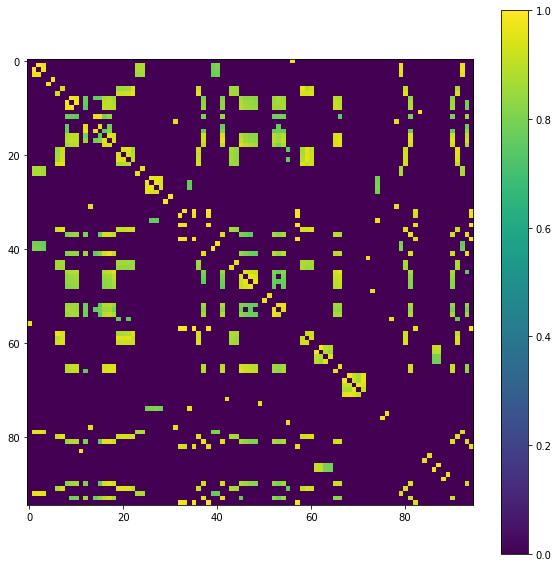

In [548]:
#visualize the correlation of the image
plt.figure(figsize=(10,10))
plt.imshow(A)
#add a colour bar where 1 is a high correlation which is bright and low correlation is dark
plt.colorbar()

We can see that we get bright patches of larger correlation among mostly dark areas where correlation was below 0.75 so was set to 0.

2.2.2

I compute the degree centrality of the nodes as the sum of the adjacency matrix across that row, and scale this by the total sum of the matrix values, as this shows the number of elements connected to the node over the total number of connections.

In [549]:
degree = A.sum(axis=1)/A.sum()
#display the degree and the index of the genes in descending order of degree centrality
print(degree)
print(np.argsort(degree)[::-1])

[0.00132309 0.00983135 0.00981963 0.00967947 0.00132808 0.00132808
 0.01582942 0.01637085 0.02417089 0.02368678 0.02375993 0.00132687
 0.0177836  0.00258393 0.00784703 0.01427688 0.02537837 0.02687344
 0.02317035 0.01703033 0.01602143 0.01717809 0.01602442 0.00720822
 0.00724487 0.00498547 0.00603676 0.00605388 0.0049414  0.00136148
 0.00136148 0.00259561 0.00797856 0.00789966 0.00338481 0.00798817
 0.01624474 0.02348941 0.00800026 0.00663649 0.00673836 0.02593545
 0.00129775 0.0154278  0.01520204 0.02257293 0.01997598 0.02070872
 0.01845789 0.00129993 0.0013113  0.0013113  0.02417308 0.02262544
 0.02441957 0.00441258 0.00132309 0.0080158  0.01609655 0.01630774
 0.01626744 0.00624026 0.00614846 0.00589032 0.00581415 0.02336957
 0.02442424 0.0050706  0.00508466 0.00510002 0.00494561 0.00515172
 0.00129775 0.00129993 0.00563156 0.0013242  0.0013242  0.0012976
 0.00258577 0.00969039 0.01632768 0.02523066 0.00772518 0.00132687
 0.00130092 0.00130092 0.00594816 0.00597437 0.00130866 0.00130

In [550]:
print("Top 5 ranking genes index: ", np.argsort(degree)[::-1][:5])
#print the corresponding degrees of the top 5 ranking genes
print(degree[np.argsort(degree)[::-1][:5]])

Top 5 ranking genes index:  [17 41 16 81 90]
[0.02687344 0.02593545 0.02537837 0.02523066 0.02487023]


2.2.3

The weighted symmetric normalized Laplacian matrix $L_{sym}$ for a graph with $n$ nodes and edge weights given by the matrix $W$ can be defined as:

$$L_{sym} = I - D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$$

where $I$ is the identity matrix and $D$ is a diagonal matrix with diagonal elements $D_{ii} = \sum_{j=1}^n W_{ij}$.

In [551]:
weighted_degree = A.sum(axis=1) 
# create diagonal matrix of degree
D = np.diag(weighted_degree)

In [552]:
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

In [554]:
# return the smallest magnitude eigenvectors and eigenvalues
import scipy
eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(L_norm, L_norm.shape[0], which='SM', return_eigenvectors=True)

In [555]:
#print the eigenvalues
eigenvals

array([-5.54786750e-16, -3.54123226e-16, -3.10690328e-16, -2.62779512e-16,
       -2.22044605e-16, -1.75438376e-16, -9.27904751e-17, -8.14521406e-17,
       -1.46427396e-17, -2.58229912e-18,  9.49598058e-17,  1.27510467e-16,
        2.74764780e-16,  3.09748501e-16,  4.67476280e-16,  6.21762811e-16,
        8.65716968e-16,  1.33226763e-15,  4.40674341e-01,  7.09824816e-01,
        8.09205368e-01,  8.74415544e-01,  9.49448789e-01,  9.93084679e-01,
        1.00281813e+00,  1.01076222e+00,  1.02782108e+00,  1.04465433e+00,
        1.04783531e+00,  1.04956517e+00,  1.05073999e+00,  1.05146914e+00,
        1.05162853e+00,  1.05387651e+00,  1.05532375e+00,  1.05570299e+00,
        1.05633592e+00,  1.05665956e+00,  1.05968737e+00,  1.07419326e+00,
        1.07444423e+00,  1.07577484e+00,  1.07772569e+00,  1.07840825e+00,
        1.07930189e+00,  1.07966193e+00,  1.08036281e+00,  1.08130455e+00,
        1.08252594e+00,  1.08512021e+00,  1.08600827e+00,  1.09526489e+00,
        1.11444086e+00,  

In [556]:
#print the eigenvectors
eigenvecs

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.48320924e-03, -1.57431825e-04, -3.19649266e-18, ...,
         2.11797229e-33,  2.53651164e-17, -7.86032301e-33],
       [ 7.47874866e-03, -1.57337983e-04,  0.00000000e+00, ...,
         0.00000000e+00, -4.26304453e-20,  0.00000000e+00],
       ...,
       [ 7.40610189e-03, -1.55809640e-04,  1.95156391e-18, ...,
        -7.39557099e-32,  1.11022302e-16, -9.24446373e-33],
       [-1.49549271e-02, -7.37900170e-03, -4.66469801e-04, ...,
         1.15963957e-17, -9.31176433e-16, -2.03838698e-19],
       [ 2.49596043e-04, -8.99307916e-02,  1.05521922e-03, ...,
        -6.84360270e-18, -2.88407547e-27,  2.09619157e-17]])

I will find the last eigenvalue of the Laplacian below machine epsilon and the first one after, which is the 19th so there are 18 eigenvalues at 0. We consider 1e-14 to be the threshold for 0.

In [557]:
#cutoff at 1e-14
eigenvals[17],eigenvals[18]

(1.3322676295501878e-15, 0.4406743414282045)

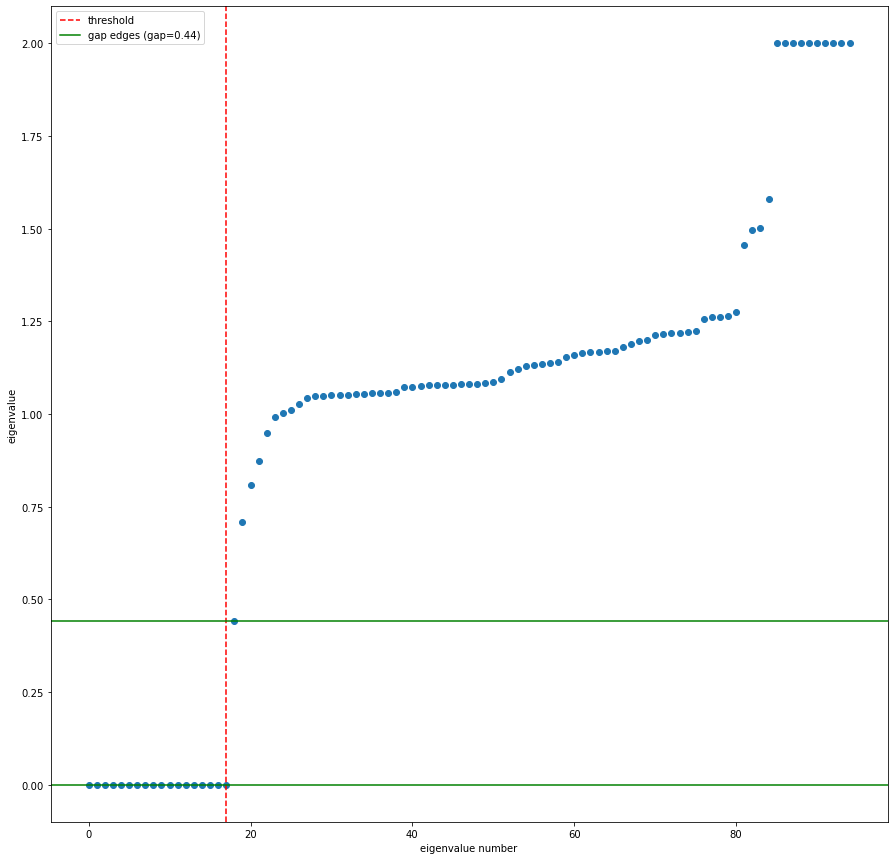

In [558]:
#plot the spectrum of the eigenvalues to show the gap of 0.44 between the last eigenvalue we consider to be 0 
#and the first nonzero one
plt.figure(figsize=(15,15))
plt.scatter(x=range(len(eigenvals)),y=eigenvals)
plt.xlabel("eigenvalue number")
plt.ylabel("eigenvalue")
plt.axvline(17,1e-15, color="red",linestyle="--",label="threshold")
plt.axhline(1e-14,color="green",label="gap edges (gap=0.44)")
plt.axhline(0.4407,color="green")

plt.legend()

In [559]:
#number of 0 eigenvalues, number of connected components
print(len(eigenvals[:18]))
r=18

18


r=18 where r is the number of 0 eigenvalues. This tells us that there there are 18 connected components in our graph.

Multiplying both sides by $D^{\frac{1}{2}}$ on the left and right, we get:

$$D^{\frac{1}{2}} L_{norm} D^{\frac{1}{2}} (D^{\frac{1}{2}} x) = \lambda (D^{\frac{1}{2}} x)$$

Substituting the expression for $L_{norm}$ and simplifying, we get:

$$(I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}}) (D^{\frac{1}{2}} x) = \lambda (D^{\frac{1}{2}} x)$$

Multiplying out, we get:

$$D^{\frac{1}{2}} x - D^{-\frac{1}{2}} W D^{-\frac{1}{2}} D^{\frac{1}{2}} x = \lambda D^{\frac{1}{2}} x$$

Simplifying further, we get:

$$(I - D^{-\frac{1}{2}} W D^{-\frac{1}{2}}) (D^{\frac{1}{2}} x) = \lambda D^{\frac{1}{2}} x$$

This shows that the eigenvectors of $L_{norm}$ are related to the eigenvectors of $L$ through a similarity transformation by $D^{-\frac{1}{2}}$. Therefore, the number of connected components of the graph can be determined by counting the number of 0 eigenvalues of $L_{norm}$, which is equal to the number of 0 eigenvalues of $L$.

2.2.4

Form a matrix of size 95 by r with the eigenvectors of U, the eigenvalues of A which correspond to 0 eigenvalues, and normalising the rows.

In [560]:
#index the first r columns of U
U = eigenvecs[:,:r]

In [561]:
#make T be U with rows normalised
T = U/np.sqrt((U**2).sum(axis=1))[:,np.newaxis]

In [562]:
#checking that T indeed has rows normalised
np.linalg.norm(T[1])

1.0

$$ W(C) = \sum_{k=1}^{|C|} \sum_{i=1}^{n} \left(|x_{i} - c_k|^2 \cdot \delta_{k,l_i}\right) $$

where $C$ is the set of all clusters in the clustering solution, $|C|$ is the number of clusters, $n$ is the number of samples in the dataset, $x_i$ is the $i$-th sample in the dataset, $c_k$ is the centroid of the $k$-th cluster, and $l_i$ is the label of the $i$-th sample, which indicates the cluster that it belongs to. $\delta_{k,l_i}$ is the Kronecker delta function, which is 1 if $k=l_i$ and 0 otherwise.

In [563]:
def within_distance(X, labels, centroids):
    """function that computes the within-cluster distance of T """
    n_samples, n_features = X.shape
    n_clusters = len(centroids)
    #initialise the within cluster distance to 0
    wc = 0
    for k in range(n_clusters):
        #set a mask of the indices corresponding to the kth cluster
        mask = (labels == k)
        #find the points in that cluster
        points = X[mask]
        #find the norm  of the distance from the points to the centroids
        distances = np.linalg.norm(points - centroids[k], axis=1)
        #the within-cluster distance is the norm squared
        wc += np.sum(distances ** 2)
    return wc

In [564]:
def kmeans(X, k, seed=0, max_iter=15):
    """kmeans algorithm"""
    n_samples, n_features = X.shape
    np.random.seed(seed)
    labels = np.random.randint(low=0, high=k, size=n_samples)
    while len(np.unique(labels)) < k:    
        labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]
        # print(n_features == centroids[i].shape[1])
    
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        # print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            # print('Labels unchanged! Terminating k-means.')
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            # print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    return labels, centroids

I will initialise a list to store the scores across a large range of k values, where for each one I calculate the within distance across 500 iterations. Within-distance measures the strength of cross cluster connections for the clustering hence we want to minimise this quantity using the least possible number of clusters so we are not trivially minimising it. I set a different seed for each iteration and take the minimum across the 500 iterations as the minimum corresponds to the best performance of the kmeans algorithm.

In [565]:
#initialise scores list
scores=[]
#iterate over k
for k in range(2,50):
    #set score to large initial value so first value gives a minimum 
    score=1000
    for j in range(200):
        labels,centroids = kmeans(T,k,seed=j)
        score = min(score,within_distance(T,labels,centroids))
        
    scores.append(score)

Text(0, 0.5, 'W')

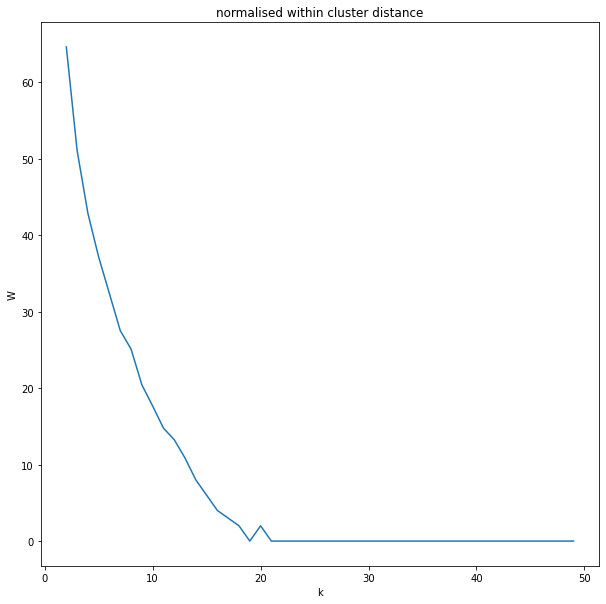

In [566]:
#plot the smallest normalised within cluster distance across iterations for each k
plt.figure(figsize=(10,10))
plt.plot(range(2,50),scores)
plt.title("normalised within cluster distance")
plt.xlabel("k")
plt.ylabel("W")

The plot is curve up to about k=18 then becomes flat where the minimum has hit zero beyond 18 meaning that the clusters are perfectly separated according to the within distance for any k greater than 18. We only need 18 clusters therefore, no need to further divide into more clusters. This makes sense as it corresponds to the 18 connected components we identified from the eigenvalues of the weighted Laplacian. Hence essentially when k=18, the kmeans algorithm finds all the connected components.

In [567]:
#take elbow at 18
labels = kmeans(T,18)[0]

In [569]:
labels

array([12,  0,  0,  0,  7,  7, 15, 15,  1,  1,  1,  6,  1, 14,  1,  1,  1,
        1,  1, 15, 15, 15, 15,  0,  0, 11, 11, 11, 11,  9,  9, 14, 10, 10,
       11, 10, 15,  1, 10,  0,  0,  1, 17, 15, 15,  1,  1,  1,  1, 13,  9,
        9,  1,  1,  1, 15, 12, 10, 15, 15, 15,  4,  4,  4,  4,  1,  1, 14,
       14, 14, 14, 14, 17, 13, 11, 17, 17, 15, 14,  0, 15,  1, 10,  6,  2,
        2,  4,  4, 13, 13,  1, 15,  0,  1, 10], dtype=int64)

In [577]:
#find the largest sizes of the clusters
sizes=[len(labels[labels==i]) for i in range(17)]
print(np.sort(sizes)[::-1][:5])

[23 16  9  8  7]


In [573]:
#the index of the largest cluster size
np.argmax(sizes)

1

The largest 5 clusters have sizes 23, 16, 9, 8, 7 so the clusters are very unbalanced in size (some have size just 1). The sizes of the clusters correspond to the sizes of the connected components. 23 nodes hence form a highly correlated group whilst some nodes are uncorrelated with everything.

2.2.5

In [327]:
#print a boolean filter of which elements are in the biggest cluster
indices = (labels==np.argmax(sizes))
indices

23


array([False, False, False, False, False, False, False, False,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
        True,  True,  True,  True, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False,  True, False])

I will recalculate an adjacency matrix for the subset of the biggest cluster and the corresponding weighted normalised Laplacian matrix. Find the eigenvalues of the new Laplacian and check that the first eigenvalue is 0. It is, which means we have a single connected components and hence can use the second eigenvector to partition the space. Make a binary partition of the space which is defined such that the positive values of the eigenvector go into one partition whilst the negative values go into the other partition. Hence it the biggest cluster can be divided into further groups easily we should see a good partition.

In [328]:
#index on the adjacency matrix to find the adjacency matrix of the subset corresponding to the biggest cluster
A_sub = A[indices][:,indices]
A_sub.shape

(23, 23)

In [330]:
weighted_degree_sub = A_sub.sum(axis=1) 

# create diagonal matrix of degree
D_sub = np.diag(weighted_degree_sub)

In [331]:
weighted_degree_sqrt_sub = 1.0 / np.sqrt(weighted_degree_sub)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt_sub = np.diag(weighted_degree_sqrt_sub)

# define the normalised Laplacian
L_norm_sub = np.eye(A_sub.shape[0]) - D_inv_sqrt_sub.dot(A_sub.dot(D_inv_sqrt_sub))

In [333]:
eigenvals_sub, eigenvecs_sub = scipy.sparse.linalg.eigsh(L_norm_sub, L_norm_sub.shape[0], which='SM', return_eigenvectors=True)

In [334]:
eigenvals_sub
#one zero eigenvalue as expected meaning 1 connected component

array([1.11022302e-15, 7.09824816e-01, 9.49448789e-01, 9.93084679e-01,
       1.00281813e+00, 1.01076222e+00, 1.02782108e+00, 1.04465433e+00,
       1.04783531e+00, 1.04956517e+00, 1.05073999e+00, 1.05162853e+00,
       1.05387651e+00, 1.05532375e+00, 1.05570299e+00, 1.05633592e+00,
       1.05665956e+00, 1.08600827e+00, 1.09526489e+00, 1.11444086e+00,
       1.12087585e+00, 1.15353425e+00, 1.21379412e+00])

In [335]:
#visualise the second eigenvector
eigenvecs_sub[1]

array([-0.21591337,  0.10758434,  0.05769872, -0.07823639, -0.38060496,
        0.23502452,  0.02095027, -0.08786073,  0.26192997,  0.04417337,
       -0.14195074,  0.02870913, -0.03683932, -0.05697233, -0.18327776,
       -0.28631471, -0.640002  , -0.01074602, -0.01540922,  0.14123525,
       -0.1830264 ,  0.1997839 ,  0.0953104 ])

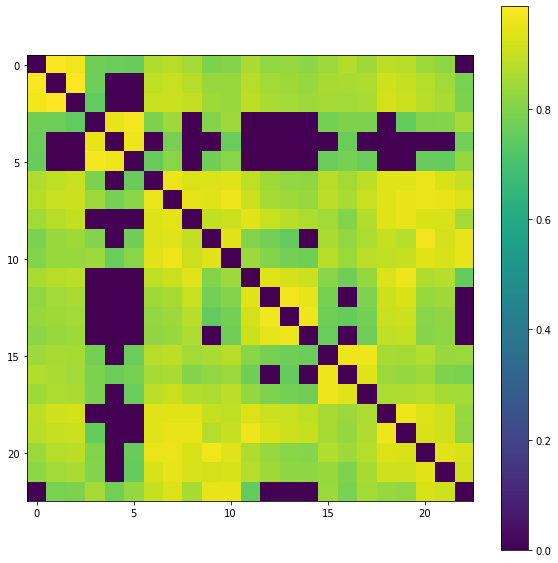

In [338]:
#visualisation of the subset
plt.figure(figsize=(10,10))
plt.imshow(A_sub)
plt.colorbar()

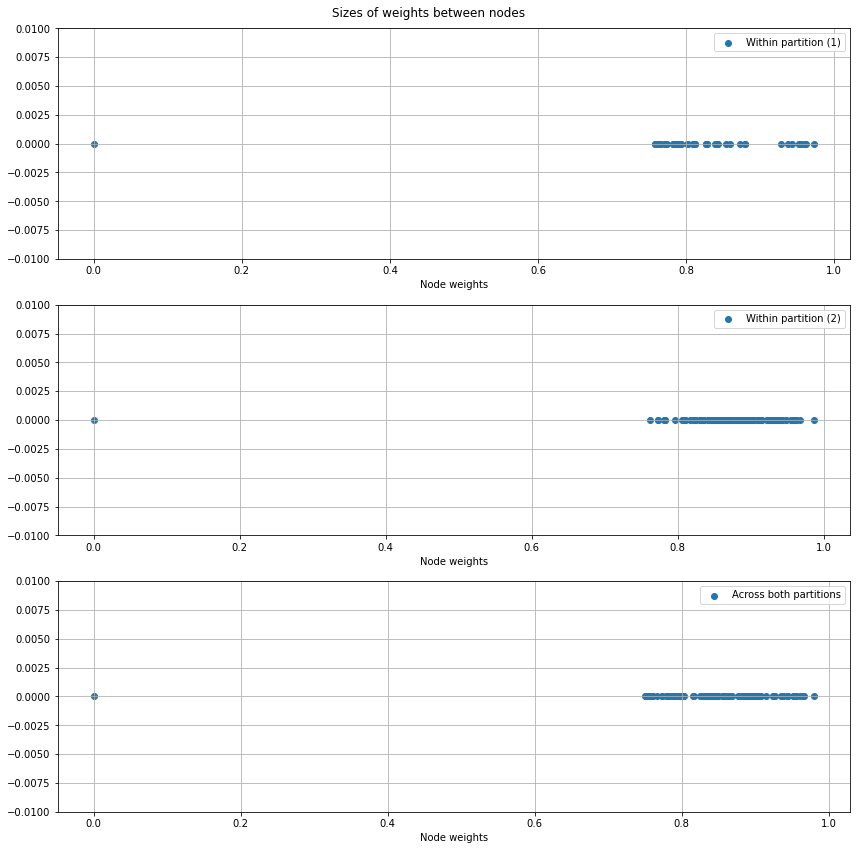

In [340]:
#find the second eigenvector of the smaller Laplacian
vector2 = eigenvecs_sub[:, 1]

# take the first eigenvector corresponding to the first (minimum) non-zero eigenvalue
spectral_partition = vector2.copy()

# partition the original dataset
spectral_partition[vector2<0] = -1
spectral_partition[vector2>0] = 1

#get the indices where the eigenvector is positive and negative
indices1 = np.arange(23)[spectral_partition==-1]
indices2 = np.arange(23)[spectral_partition==1]

#create A1 which is the adjacency matrix of the first partition only
#A2 is just the 2nd partition
#A_cross is the adjacency matrix of the cross partition weights
A1 = A_sub[indices1][:, indices1]
A2 = A_sub[indices2][:, indices2]
A_cross = A_sub[indices1][:, indices2]

A1w = np.unique(A1.flatten()) # avoid counting twice
A2w = np.unique(A2.flatten())
A3w = np.unique(A_cross.flatten())

weights = [A1w, A2w, A3w]

#plot the weights within the 3 adjacency matrices calculated above
titles = ['Within partition (1)', 'Within partition (2)', 'Across both partitions']
plt.figure(figsize=(12,12))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.scatter(x=weights[i], y=np.zeros(len(weights[i])), label=titles[i])
    plt.ylim(-0.01, 0.01)
    plt.xlabel('Node weights')
    plt.legend(loc='best')
    plt.grid()

plt.suptitle('Sizes of weights between nodes')
plt.tight_layout()

If the partition were done efficiently, we would observe that the weights within the partitions would be close to 1, whilst across the partition they would be close to 0 as if we are separating points we would hope they would not be strongly correlated. We see that most of the points are closely correlated (>0.8) both in and cross partitions. Of course, we set less than 0.75 to 0 but still, we do not get many 0 values from the histogram of the cross partition. We can infer from this that the partition is not doing very well. We are using the biggest cluster from clustering which we know is connected so we do not expect to be able to perfectly partition the cluster further, however we can see the partition is very poor as this cluster has mostly very strongly correlated values.

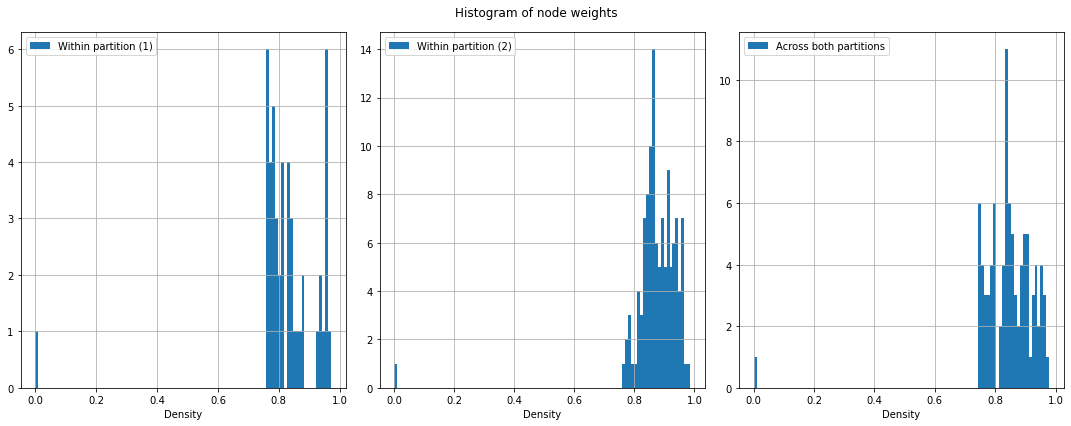

In [341]:
#histograms of the distribution of weights for the 2 partitions and the weights across the partitions
plt.figure(figsize=(15, 6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(weights[i], label=titles[i], bins=100)
    plt.xlabel('Density')
    plt.legend(loc='best')
    plt.grid()

plt.suptitle('Histogram of node weights')
plt.tight_layout()

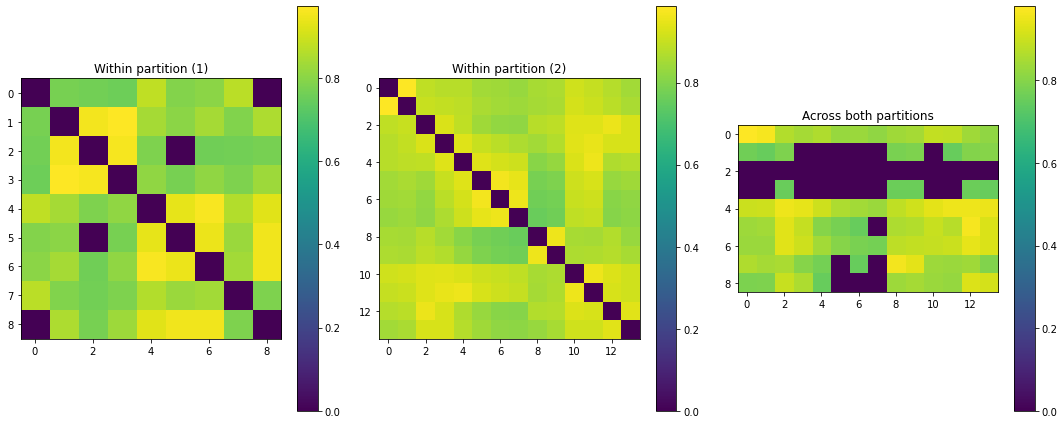

In [342]:
adj_matrices = [A1, A2, A_cross]
plt.figure(figsize=(15, 6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(adj_matrices[i])
    plt.colorbar()
    plt.title(titles[i])

plt.tight_layout()

Again, we see the within cluster adjacency matrix has mostly strong links and the cross partitions is majority bright colours (strong links), though there is a smaller darker band in the cross partition image. The sizes of the 2 partitions are 9 and 13, and it is difficult to identify any block diagonality in the A matrix of this size. The partition has performed well in the sense that points in the same partition are highly correlated but this is trivially satisfied.

There has to be a zero according to the diagonal, weight of node to itself.

2.2.6

I will find the degree centrality of the 5 nodes with highest degree in both the whole graph and the subgraph.

In [350]:
degree = A.sum(axis=1)/A.sum()

In [351]:
print("Top 5 ranking genes index: ", np.argsort(degree)[::-1][:5])
print(degree[np.argsort(degree)[::-1][:5]])

Top 5 ranking genes index:  [17 41 16 81 90]
[0.02687344 0.02593545 0.02537837 0.02523066 0.02487023]


In [362]:
subgraph_nodes = np.arange(95)[idx]

In [376]:
idx = labels==5
A_sub = A[idx][:, idx]
degree = A_sub.sum(axis=1)/A_sub.sum()
sort_idx = np.argsort(degree)[::-1]
top_5_idx = subgraph_nodes[sort_idx][:5]

In [377]:
print("Top 5 ranking genes index: ", top_5_idx)
print(degree[np.argsort(degree)[::-1][:5]])

Top 5 ranking genes index:  [17 41 16 81 90]
[0.05289032 0.05104425 0.04994785 0.04965714 0.04894775]


We get the same indices for the 5 highest degree nodes (index in the larger adjacency matrix) so the highest degree nodes overall are in the largest cluster. This makes sense as the largest cluster is of size 23, so it makes sense that the most connected nodes would be in this cluster, especially as we know the clusters correspond to connected components.

The degree centralities of the 5 highest nodes higher in the subgraph as they correspond to the same nodes, therefore have the same number of connections as before (we can assume this only because each cluster is a connected component) but when we scale the degree centrality we are scaling by less, as there are fewer total weights in the overall graph.

## Task 3: Mastery component  (25 marks)

**Please delete this section if you are not a master student**



#### 3.1 Betweenness Centrality (10 marks)
3.1.1

#### 3.2 Hidden Markov Models (15 marks)
3.2.1

3.2.2

3.2.3

3.2.4

3.2.5